EDA questions:

effect of pool on price, pool and condo

How does having a pool affect property values?

filtering out outliers in price

what does the low end of sale prices look like?

Need to look at lot size more closely on the low end

Does it make sense to do all this EDA then filter the home prices at the end? It might filter out some noise at the last second, but it also makes it harder to detect the more granular noise during the initial EDA.

In [ ]:
# Need to add this code after done investigating nulls

# # Converting floats to int

# cols_to_int = ['bedrooms','bathrooms','squareFootage','lotSize','yearBuilt','lastSalePrice','floorCount']

# data[cols_to_int] = data[cols_to_int].astype(int)

# data.info()

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [2]:
# Loading data from SQLite to pandas

path_to_db = '/workspaces/mds8-final-project-bmh/data/raw/rentcast_FL.db'
conn = sqlite3.connect(path_to_db)
query = """SELECT * FROM properties"""
data = pd.read_sql(query, conn)
conn.close()
data.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,foundationType,garage,garageSpaces,garageType,pool,roomCount,unitCount,viewType
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
1,"5018-Coquina-Key-Dr-SE,-Saint-Petersburg,-FL-3...","5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,FL,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,...,0,2.0,None,0,NaN,None,True,NaN,1.0,Water
2,"1070-Rhonda-Rd,-Jacksonville,-FL-32254","1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,FL,32254,Duval,30.339189,-81.717711,Single Family,3.0,...,0,1.0,None,1,4.0,Garage,False,NaN,1.0,None
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.999305,-80.118487,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None


In [3]:
data.shape

(145617, 35)

In [136]:
avg_price = data['lastSalePrice'].mean()

print(f'{avg_price:,.2f}')

468,110.64


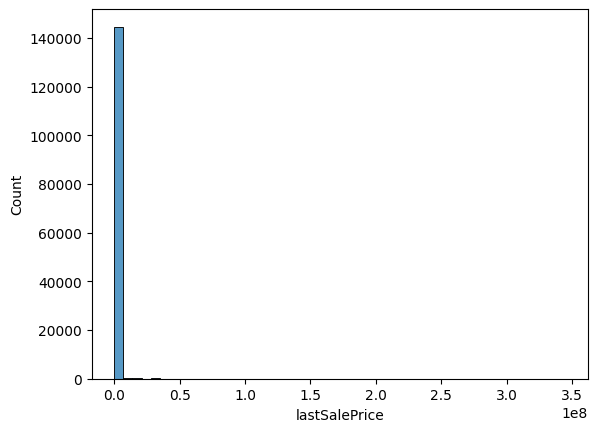

In [4]:
sns.histplot(data['lastSalePrice'], bins=50)
plt.show()

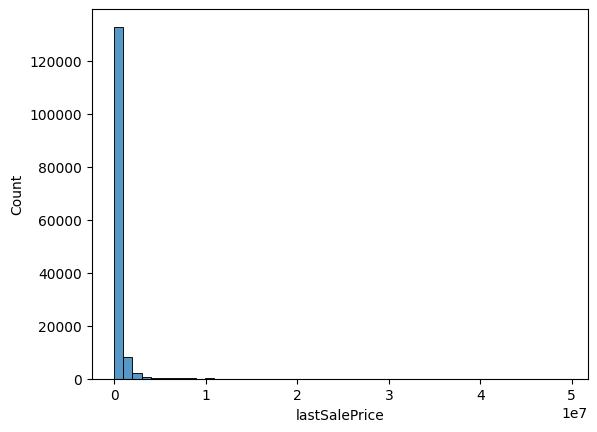

In [5]:
# Limiting price to under 50000000

data = data[data['lastSalePrice'] < 50000000]

sns.histplot(data['lastSalePrice'], bins=50)
plt.show()

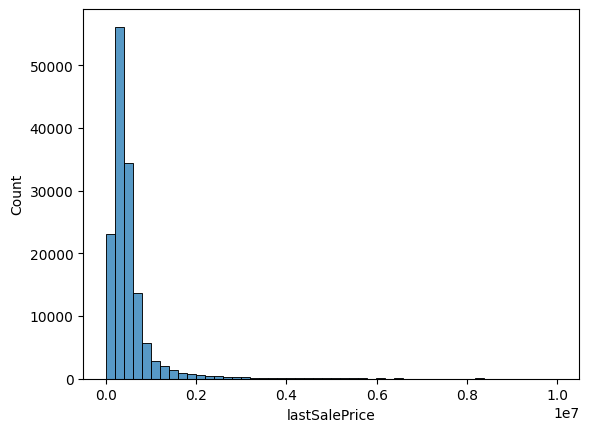

In [6]:
# Limiting price to under 10,000,000

data = data[data['lastSalePrice'] < 10000000]

sns.histplot(data['lastSalePrice'], bins=50)
plt.show()

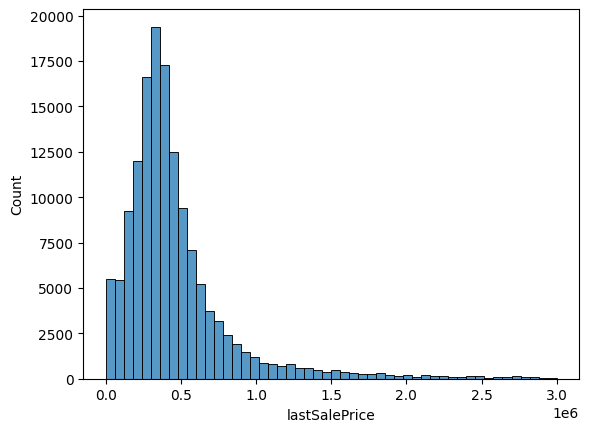

In [7]:
# Limiting price to under 3,000,000

data = data[data['lastSalePrice'] < 3000000]

sns.histplot(data['lastSalePrice'], bins=50)
plt.show()

In [8]:
len(data[data['lastSalePrice'] < 3000000])

143005

In [9]:
len(data[data['lastSalePrice'] < 2000000])

141023

In [10]:
# Converting zip code to string

data['zipCode'] = data['zipCode'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143005 entries, 1 to 145616
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                143005 non-null  object 
 1   formattedAddress  143005 non-null  object 
 2   city              143005 non-null  object 
 3   state             143005 non-null  object 
 4   zipCode           143005 non-null  object 
 5   county            142885 non-null  object 
 6   latitude          143005 non-null  float64
 7   longitude         143005 non-null  float64
 8   propertyType      141092 non-null  object 
 9   bedrooms          124425 non-null  float64
 10  bathrooms         126080 non-null  float64
 11  squareFootage     128325 non-null  float64
 12  lotSize           126510 non-null  float64
 13  yearBuilt         125324 non-null  float64
 14  subdivision       116478 non-null  object 
 15  zoning            85250 non-null   object 
 16  lastSaleDate      143005 

In [11]:
# Creating column with average 30 year mortgage rates by month

data.lastSaleDate = pd.to_datetime(data.lastSaleDate)

data['year_month'] = data['lastSaleDate'].dt.to_period('M')

m_rate = {
    '2024-03':0.0682,
    '2024-04':0.0699,
    '2024-05':0.076,
    '2024-06':0.0692,
    '2024-07':0.0685,
    '2024-08':0.065,
    '2024-09':0.0618,
    '2024-10':0.0643,
    '2024-11':0.0681,
    '2024-12':0.0672,
    '2025-01':0.0696,
    '2025-02':0.0684,
    '2025-03':0.0668
}

data['year_month'] = data['year_month'].dt.strftime('%Y-%m')

data['m_rate'] = data['year_month'].map(m_rate)


/tmp/ipykernel_16185/117635043.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['lastSaleDate'].dt.to_period('M')


In [12]:
# Dropping columns with few values or that appear redundant/unnecessary

drop_cols = ['zoning','hoa','architectureType','coolingType','heatingType','garageSpaces','garageType','roomCount','foundationType','exteriorType'] 
# initially dropped viewType, but saving it for now because of later EDA concerns

data = data.drop(drop_cols, axis=1)
data.shape

(143005, 27)

In [13]:
data['propertyType'].value_counts()

propertyType
Single Family    98522
Condo            22401
Land             11756
Manufactured      3828
Multi-Family      2359
Townhouse         1760
Apartment          466
Name: count, dtype: int64

In [14]:
# Can likely fill these with 1, but need to investigate multi-family category



In [15]:
# Dropping Land category as outside the scope of the project

data = data[data['propertyType'] != 'Land']
data.shape

(131249, 27)

In [16]:
# Very few apartments--investigating further

apt = data[data['propertyType'] == 'Apartment']
apt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466 entries, 345 to 145394
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                466 non-null    object             
 1   formattedAddress  466 non-null    object             
 2   city              466 non-null    object             
 3   state             466 non-null    object             
 4   zipCode           466 non-null    object             
 5   county            465 non-null    object             
 6   latitude          466 non-null    float64            
 7   longitude         466 non-null    float64            
 8   propertyType      466 non-null    object             
 9   bedrooms          426 non-null    float64            
 10  bathrooms         442 non-null    float64            
 11  squareFootage     440 non-null    float64            
 12  lotSize           248 non-null    float64            
 13  yearB

In [17]:
apt.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,m_rate
count,466.000000,466.000000,426.000000,442.000000,440.000000,2.480000e+02,425.000000,4.660000e+02,466.000000,466.000000,466.000000,140.000000,466.000000,192.000000,466.000000
mean,26.976882,-80.988243,1.913146,1.682127,1391.436364,8.333732e+05,1971.830588,5.927704e+05,0.218884,0.195279,0.010730,1.178571,0.126609,1.640625,0.068398
std,1.352986,1.184551,1.415699,1.470102,1391.214921,1.275023e+07,24.602203,5.898835e+05,0.413934,0.396841,0.103137,0.498456,0.332892,1.760835,0.003638
min,24.660362,-87.314542,0.000000,1.000000,100.000000,2.500000e+01,1700.000000,5.000000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.061800
25%,25.928776,-81.733756,1.000000,1.000000,705.000000,6.000000e+03,1960.000000,2.000000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.067200
50%,26.230311,-80.302039,2.000000,1.000000,935.500000,8.927000e+03,1970.000000,3.650000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.068500
75%,27.967398,-80.142104,2.000000,2.000000,1347.000000,1.535050e+04,1983.000000,7.315000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.069600
max,30.433831,-80.032465,16.000000,17.500000,9382.000000,2.008116e+08,2024.000000,2.943750e+06,1.000000,1.000000,1.000000,5.000000,1.000000,14.000000,0.076000


In [ ]:
# Very large max and standard deviation values--this is probably a mixture of large buildings and single units (reasons for listing as apartment vs. condo unclear)
# Checking a few on Zillow

apt.head(10)

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
345,"2200-E-Hallandale-Beach-Blvd,-Apt-211,-Halland...","2200 E Hallandale Beach Blvd, Apt 211, Halland...",Hallandale Beach,FL,33009,Broward,25.985639,-80.126821,Apartment,1.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
1291,"11113-Airport-Dr,-Sebastian,-FL-32958","11113 Airport Dr, Sebastian, FL 32958",Sebastian,FL,32958,Indian River,27.799945,-80.498588,Apartment,4.0,...,1,1,0,1.0,0,False,2.0,None,2024-03,0.0682
1664,"10764-70th-Ave,-Unit-7305,-Seminole,-FL-33772","10764 70th Ave, Unit 7305, Seminole, FL 33772",Seminole,FL,33772,Pinellas,27.835130,-82.788877,Apartment,2.0,...,0,0,0,1.0,0,True,1.0,Average,2024-03,0.0682
1872,"200-S-11th-St,-Ste-103,-Leesburg,-FL-34748","200 S 11th St, Ste 103, Leesburg, FL 34748",Leesburg,FL,34748,Lake,28.809777,-81.882210,Apartment,2.0,...,1,1,0,2.0,0,False,NaN,None,2024-03,0.0682
2705,"1514-Sw-6th-St,-Apt-4,-Miami,-FL-33135","1514 Sw 6th St, Apt 4, Miami, FL 33135",Miami,FL,33135,Miami-Dade,25.767258,-80.219963,Apartment,2.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
3387,"900-Atlantic-Shores-Blvd,-Apt-107,-Hallandale-...","900 Atlantic Shores Blvd, Apt 107, Hallandale ...",Hallandale Beach,FL,33009,Broward,25.994632,-80.139489,Apartment,1.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
3693,"3051-S-Palm-Aire-Dr,-Apt-201,-Pompano-Beach,-F...","3051 S Palm Aire Dr, Apt 201, Pompano Beach, F...",Pompano Beach,FL,33069,Broward,26.217965,-80.164739,Apartment,3.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
4143,"805-81st-St,-Apt-1,-Miami-Beach,-FL-33141","805 81st St, Apt 1, Miami Beach, FL 33141",Miami Beach,FL,33141,Miami-Dade,25.866934,-80.127326,Apartment,1.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
4144,"805-81st-St,-Apt-2,-Miami-Beach,-FL-33141","805 81st St, Apt 2, Miami Beach, FL 33141",Miami Beach,FL,33141,Miami-Dade,25.866934,-80.127326,Apartment,1.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
4289,"504-Chelsee-Way,-Lake-Placid,-FL-33852","504 Chelsee Way, Lake Placid, FL 33852",Lake Placid,FL,33852,Highlands,27.241486,-81.330743,Apartment,2.0,...,1,1,0,1.0,0,False,2.0,None,2024-03,0.0682


In [19]:
# These few values are inconsistent in terms of what they are--some are condos, some are rentals, others are unclear. Dropping this category.

data = data[data['propertyType'] != 'Apartment']
data.shape

(130783, 27)

In [20]:
# Investigating nulls in bedroom and bathroom for condos

data[(data['bedrooms'].isna()) & (data['propertyType'] == 'Condo')]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
11,"4250-Biscayne-Blvd,-Apt-510,-Miami,-FL-33137","4250 Biscayne Blvd, Apt 510, Miami, FL 33137",Miami,FL,33137,Miami-Dade,25.815609,-80.189226,Condo,NaN,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
255,"1621-Gulf-Blvd,-Apt-705,-Clearwater-Beach,-FL-...","1621 Gulf Blvd, Apt 705, Clearwater Beach, FL ...",Clearwater Beach,FL,33767,Pinellas,27.938601,-82.838433,Condo,NaN,...,1,1,0,1.0,1,True,1.0,Water,2024-03,0.0682
320,"505-Mandalay-Ave,-Apt-66,-Clearwater-Beach,-FL...","505 Mandalay Ave, Apt 66, Clearwater Beach, FL...",Clearwater Beach,FL,33767,Pinellas,27.982908,-82.824513,Condo,NaN,...,0,0,0,3.0,1,True,1.0,None,2024-03,0.0682
465,"999-Fort-Pickens-Rd,-Apt-501,-Gulf-Breeze,-FL-...","999 Fort Pickens Rd, Apt 501, Gulf Breeze, FL ...",Gulf Breeze,FL,32561,Escambia,30.327714,-87.163409,Condo,NaN,...,1,1,0,1.0,0,False,1.0,None,2024-03,0.0682
577,"2900-45th-St-S,-Apt-1,-Gulfport,-FL-33711","2900 45th St S, Apt 1, Gulfport, FL 33711",Gulfport,FL,33711,Pinellas,27.741663,-82.693932,Condo,NaN,...,1,1,0,1.0,0,True,1.0,Water,2024-03,0.0682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145333,"6500-Valen-Way,-Apt-301,-Naples,-FL-34108","6500 Valen Way, Apt 301, Naples, FL 34108",Naples,FL,34108,Collier,26.227702,-81.808722,Condo,NaN,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
145338,"9138-Chula-Vista-St,-Unit-12702,-Naples,-FL-34113","9138 Chula Vista St, Unit 12702, Naples, FL 34113",Naples,FL,34113,Collier,26.071624,-81.694981,Condo,NaN,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
145440,"414-School-Rd,-Apt-96,-Indian-Harbour-Beach,-F...","414 School Rd, Apt 96, Indian Harbour Beach, F...",Indian Harbour Beach,FL,32937,Brevard,28.149827,-80.590093,Condo,NaN,...,1,1,0,NaN,0,False,1.0,None,2024-06,0.0692
145487,"4084-Northlight-Dr,-Naples,-FL-34112","4084 Northlight Dr, Naples, FL 34112",Naples,FL,34112,Collier,26.137556,-81.758128,Condo,NaN,...,0,0,0,NaN,0,False,1.0,None,2024-06,0.0692


In [21]:
# I suspected condos with null for bedrooms would be studio apartments, but checking these on Zillow shows no pattern.

In [22]:
data[(data['bedrooms'].isna()) & (data['bathrooms'].isna())]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
86,"7101-Carmel-Dr,-Tallahassee,-FL-32309","7101 Carmel Dr, Tallahassee, FL 32309",Tallahassee,FL,32309,Leon,30.554501,-84.189851,Single Family,NaN,...,1,0,0,1.0,1,False,1.0,None,2024-03,0.0682
175,"971-Mendel-Ave,-Marco-Island,-FL-34145","971 Mendel Ave, Marco Island, FL 34145",Marco Island,FL,34145,Collier,25.917499,-81.724744,Single Family,NaN,...,0,0,0,1.0,0,True,1.0,None,2024-03,0.0682
196,"110-Nw-53rd-St,-Deerfield-Beach,-FL-33064","110 Nw 53rd St, Deerfield Beach, FL 33064",Deerfield Beach,FL,33064,Broward,26.294703,-80.123712,Manufactured,NaN,...,0,0,0,1.0,0,False,1.0,None,2024-03,0.0682
197,"222-Nw-54th-St,-Deerfield-Beach,-FL-33064","222 Nw 54th St, Deerfield Beach, FL 33064",Deerfield Beach,FL,33064,Broward,26.296940,-80.125560,Manufactured,NaN,...,0,0,0,1.0,0,False,1.0,None,2024-03,0.0682
234,"1507-Redondo-Way,-Lady-Lake,-FL-32159","1507 Redondo Way, Lady Lake, FL 32159",Lady Lake,FL,32159,Sumter,28.931965,-81.961548,Single Family,NaN,...,0,0,0,NaN,1,False,1.0,None,2024-03,0.0682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145521,"2950-Glades-Cir,-Ste-13,-Weston,-FL-33327","2950 Glades Cir, Ste 13, Weston, FL 33327",Weston,FL,33327,Broward,26.140168,-80.423344,None,NaN,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
145533,"1333-E-Main-St,-Lakeland,-FL-33801","1333 E Main St, Lakeland, FL 33801",Lakeland,FL,33801,Polk,28.043833,-81.937577,None,NaN,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
145560,"520-Whitney-Ave,-Ste-B3,-Lantana,-FL-33462","520 Whitney Ave, Ste B3, Lantana, FL 33462",Lantana,FL,33462,Palm Beach,26.591424,-80.055803,None,NaN,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
145571,"624-Monroe-Ave,-Apt-401,-Cape-Canaveral,-FL-32920","624 Monroe Ave, Apt 401, Cape Canaveral, FL 32920",Cape Canaveral,FL,32920,Brevard,28.388759,-80.597482,Condo,NaN,...,0,0,0,NaN,0,False,1.0,None,2024-06,0.0692


In [23]:
# Dropping rows with nulls for bedrooms, bathrooms, or propertyType--no apparent pattern from Zillow checks

data = data.dropna(subset=['bedrooms','bathrooms','propertyType'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119088 entries, 1 to 145616
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                119088 non-null  object             
 1   formattedAddress  119088 non-null  object             
 2   city              119088 non-null  object             
 3   state             119088 non-null  object             
 4   zipCode           119088 non-null  object             
 5   county            119019 non-null  object             
 6   latitude          119088 non-null  float64            
 7   longitude         119088 non-null  float64            
 8   propertyType      119088 non-null  object             
 9   bedrooms          119088 non-null  float64            
 10  bathrooms         119088 non-null  float64            
 11  squareFootage     118878 non-null  float64            
 12  lotSize           106823 non-null  float64       

In [24]:
# Investigating properties with nulls for square footage

data[data['squareFootage'].isna()]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
2553,"4300-Sw-194th-Ave,-Ocala,-FL-34432","4300 Sw 194th Ave, Ocala, FL 34432",Ocala,FL,34432,Marion,29.145551,-82.441040,Manufactured,2.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
2680,"2019-Detroit-Dr,-Unit-2019,-Labelle,-FL-33935","2019 Detroit Dr, Unit 2019, Labelle, FL 33935",Labelle,FL,33935,Hendry,26.754504,-81.409879,Single Family,3.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
7091,"2285-Se-7th-St,-Pompano-Beach,-FL-33062","2285 Se 7th St, Pompano Beach, FL 33062",Pompano Beach,FL,33062,Broward,26.225343,-80.100922,Single Family,3.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
8507,"348-Honeycomb-Trl,-Saint-Augustine,-FL-32095","348 Honeycomb Trl, Saint Augustine, FL 32095",Saint Augustine,FL,32095,Saint Johns,29.983495,-81.359372,Single Family,4.0,...,0,0,0,1.0,1,False,NaN,None,2024-03,0.0682
10804,"4847-Se-149th-Pl,-Summerfield,-FL-34491","4847 Se 149th Pl, Summerfield, FL 34491",Summerfield,FL,34491,Marion,29.004703,-82.068130,Manufactured,3.0,...,1,1,0,1.0,0,False,1.0,None,2024-03,0.0682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141729,"29265-Sw-163rd-Ct,-Homestead,-FL-33033","29265 Sw 163rd Ct, Homestead, FL 33033",Homestead,FL,33033,Miami-Dade,25.494946,-80.453848,Single Family,3.0,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
142989,"737-Lightsey-Crossing-Ln,-Saint-Augustine,-FL-...","737 Lightsey Crossing Ln, Saint Augustine, FL ...",Saint Augustine,FL,32084,Saint Johns,29.862972,-81.366526,Single Family,4.0,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
144050,"3908-Southern-Vista-Loop,-Saint-Cloud,-FL-34772","3908 Southern Vista Loop, Saint Cloud, FL 34772",Saint Cloud,FL,34772,Osceola,28.222399,-81.269892,Single Family,4.0,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
144271,"630-Lightsey-Crossing-Ln,-Saint-Augustine,-FL-...","630 Lightsey Crossing Ln, Saint Augustine, FL ...",Saint Augustine,FL,32084,Saint Johns,29.862384,-81.365361,Single Family,4.0,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692


In [25]:
# No pattern--dropping these rows
data = data.dropna(subset=['squareFootage'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118878 entries, 1 to 145616
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                118878 non-null  object             
 1   formattedAddress  118878 non-null  object             
 2   city              118878 non-null  object             
 3   state             118878 non-null  object             
 4   zipCode           118878 non-null  object             
 5   county            118812 non-null  object             
 6   latitude          118878 non-null  float64            
 7   longitude         118878 non-null  float64            
 8   propertyType      118878 non-null  object             
 9   bedrooms          118878 non-null  float64            
 10  bathrooms         118878 non-null  float64            
 11  squareFootage     118878 non-null  float64            
 12  lotSize           106693 non-null  float64       

In [26]:
# Nulls for yearBuilt

data[data['yearBuilt'].isna()]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
409,"2704-Ne-7th-Pl,-Cape-Coral,-FL-33909","2704 Ne 7th Pl, Cape Coral, FL 33909",Cape Coral,FL,33909,Lee,26.701938,-81.958214,Single Family,4.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
451,"24-Palermo-Ln,-Palm-Coast,-FL-32164","24 Palermo Ln, Palm Coast, FL 32164",Palm Coast,FL,32164,Flagler,29.535680,-81.223645,Single Family,4.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
461,"3623-Woodmont-Dr,-Parrish,-FL-34219","3623 Woodmont Dr, Parrish, FL 34219",Parrish,FL,34219,Manatee,27.546984,-82.458032,Single Family,3.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
550,"4129-Acoma-Dr,-Ormond-Beach,-FL-32174","4129 Acoma Dr, Ormond Beach, FL 32174",Ormond Beach,FL,32174,Volusia,29.410674,-81.150928,Condo,5.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
981,"12233-Sw-Nettuno-Way,-Port-Saint-Lucie,-FL-34987","12233 Sw Nettuno Way, Port Saint Lucie, FL 34987",Port Saint Lucie,FL,34987,Saint Lucie,27.292364,-80.447499,Single Family,4.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145597,"38120-Shale-Stone-Ct,-Zephyrhills,-FL-33540","38120 Shale Stone Ct, Zephyrhills, FL 33540",Zephyrhills,FL,33540,Pasco,28.197722,-82.186716,Single Family,5.0,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
145599,"1315-Nw-132nd-Cir,-Newberry,-FL-32669","1315 Nw 132nd Cir, Newberry, FL 32669",Newberry,FL,32669,Alachua,29.665775,-82.482020,Single Family,3.0,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
145600,"111-Charmer-Trce,-Saint-Augustine,-FL-32092","111 Charmer Trce, Saint Augustine, FL 32092",Saint Augustine,FL,32092,Saint Johns,29.918559,-81.517488,Single Family,3.0,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
145613,"249-Seaforth-Dr,-Saint-Augustine,-FL-32092","249 Seaforth Dr, Saint Augustine, FL 32092",Saint Augustine,FL,32092,Saint Johns,30.017957,-81.567897,Single Family,4.0,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692


In [27]:
# This subset of nulls for yearBuilt all appear to be new builds--filling this with 2024

data['yearBuilt'] = data['yearBuilt'].fillna(2024)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118878 entries, 1 to 145616
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                118878 non-null  object             
 1   formattedAddress  118878 non-null  object             
 2   city              118878 non-null  object             
 3   state             118878 non-null  object             
 4   zipCode           118878 non-null  object             
 5   county            118812 non-null  object             
 6   latitude          118878 non-null  float64            
 7   longitude         118878 non-null  float64            
 8   propertyType      118878 non-null  object             
 9   bedrooms          118878 non-null  float64            
 10  bathrooms         118878 non-null  float64            
 11  squareFootage     118878 non-null  float64            
 12  lotSize           106693 non-null  float64       

In [28]:
# Nulls for lotSize

data[data['lotSize'].isna()]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
14,"94-Upminster-D,-Deerfield-Beach,-FL-33442","94 Upminster D, Deerfield Beach, FL 33442",Deerfield Beach,FL,33442,Broward,26.312560,-80.128489,Condo,2.0,...,0,0,0,NaN,0,False,1.0,None,2024-03,0.0682
24,"1300-S-Miami-Ave,-Unit-1508,-Miami,-FL-33130","1300 S Miami Ave, Unit 1508, Miami, FL 33130",Miami,FL,33130,Miami-Dade,25.761104,-80.193724,Condo,1.0,...,0,0,0,NaN,0,False,NaN,None,2024-03,0.0682
46,"7240-Nw-114th-Ave,-Apt-102,-Doral,-FL-33178","7240 Nw 114th Ave, Apt 102, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.839086,-80.382484,Condo,1.0,...,0,0,0,NaN,0,False,1.0,None,2024-03,0.0682
59,"2908-Se-17th-Ave,-Unit-101,-Homestead,-FL-33035","2908 Se 17th Ave, Unit 101, Homestead, FL 33035",Homestead,FL,33035,Miami-Dade,25.444631,-80.453645,Condo,3.0,...,0,0,0,1.0,0,False,NaN,None,2024-03,0.0682
70,"3000-S-Ocean-Dr,-Apt-1200,-Hollywood,-FL-33019","3000 S Ocean Dr, Apt 1200, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.994751,-80.117511,Condo,2.0,...,0,0,0,NaN,0,False,1.0,None,2024-03,0.0682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145539,"408-Ketch-Way,-Nokomis,-FL-34275","408 Ketch Way, Nokomis, FL 34275",Nokomis,FL,34275,Sarasota,27.127408,-82.460810,Single Family,2.0,...,1,1,0,1.0,1,False,1.0,Average,2024-06,0.0692
145589,"8635-Midnight-Pass-Rd,-Apt-C207,-Sarasota,-FL-...","8635 Midnight Pass Rd, Apt C207, Sarasota, FL ...",Sarasota,FL,34242,Sarasota,27.225514,-82.517908,Condo,2.0,...,1,1,0,1.0,1,False,1.0,Water,2024-06,0.0692
145599,"1315-Nw-132nd-Cir,-Newberry,-FL-32669","1315 Nw 132nd Cir, Newberry, FL 32669",Newberry,FL,32669,Alachua,29.665775,-82.482020,Single Family,3.0,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692
145600,"111-Charmer-Trce,-Saint-Augustine,-FL-32092","111 Charmer Trce, Saint Augustine, FL 32092",Saint Augustine,FL,32092,Saint Johns,29.918559,-81.517488,Single Family,3.0,...,0,0,0,NaN,0,False,NaN,None,2024-06,0.0692


In [29]:
# Checking how many with null lot size are condos

data[(data['lotSize'].isna()) & (data['propertyType'] == 'Condo')].count()

id                  10296
formattedAddress    10296
city                10296
state               10296
zipCode             10296
county              10290
latitude            10296
longitude           10296
propertyType        10296
bedrooms            10296
bathrooms           10296
squareFootage       10296
lotSize                 0
yearBuilt           10296
subdivision          8955
lastSaleDate        10296
lastSalePrice       10296
cooling             10296
heating             10296
fireplace           10296
floorCount           2018
garage              10296
pool                10296
unitCount            7217
viewType             1054
year_month          10296
m_rate              10296
dtype: int64

In [30]:
# Filling nulls in lotSize for condos with 0

data.loc[(data['propertyType'] == 'Condo') & (data['lotSize'].isnull()), 'lotSize'] = 0

In [31]:
# Filling nulls in floor count with 1

data['floorCount'] = data['floorCount'].fillna(1)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 118878 entries, 1 to 145616
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                118878 non-null  object             
 1   formattedAddress  118878 non-null  object             
 2   city              118878 non-null  object             
 3   state             118878 non-null  object             
 4   zipCode           118878 non-null  object             
 5   county            118812 non-null  object             
 6   latitude          118878 non-null  float64            
 7   longitude         118878 non-null  float64            
 8   propertyType      118878 non-null  object             
 9   bedrooms          118878 non-null  float64            
 10  bathrooms         118878 non-null  float64            
 11  squareFootage     118878 non-null  float64            
 12  lotSize           116989 non-null  float64       

In [32]:
# Dropping nulls for lastSalePrice

data = data.dropna(subset=['lastSalePrice'])

In [33]:
# Looking for remaining nulls

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118878 entries, 1 to 145616
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                118878 non-null  object             
 1   formattedAddress  118878 non-null  object             
 2   city              118878 non-null  object             
 3   state             118878 non-null  object             
 4   zipCode           118878 non-null  object             
 5   county            118812 non-null  object             
 6   latitude          118878 non-null  float64            
 7   longitude         118878 non-null  float64            
 8   propertyType      118878 non-null  object             
 9   bedrooms          118878 non-null  float64            
 10  bathrooms         118878 non-null  float64            
 11  squareFootage     118878 non-null  float64            
 12  lotSize           116989 non-null  float64       

In [34]:
null_unit = data[data['unitCount'].isna()]
null_unit

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.999305,-80.118487,Condo,2.0,...,0,0,0,1.0,0,False,NaN,None,2024-03,0.0682
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,...,0,0,0,1.0,0,False,NaN,None,2024-03,0.0682
5,"8734-Carmel-Mountain-Way,-Boynton-Beach,-FL-33473","8734 Carmel Mountain Way, Boynton Beach, FL 33473",Boynton Beach,FL,33473,Palm Beach,26.493040,-80.183199,Single Family,3.0,...,1,1,0,1.0,1,True,NaN,None,2024-03,0.0682
6,"5550-Shasta-Daisy-Pl,-Land-O-Lakes,-FL-34639","5550 Shasta Daisy Pl, Land O Lakes, FL 34639",Land O Lakes,FL,34639,Pasco,28.238025,-82.444252,Single Family,3.0,...,1,1,0,1.0,1,False,NaN,None,2024-03,0.0682
21,"4355-Perkinshire-Ln,-Apt-M204,-Orlando,-FL-32822","4355 Perkinshire Ln, Apt M204, Orlando, FL 32822",Orlando,FL,32822,Orange,28.500187,-81.311581,Condo,3.0,...,1,1,0,1.0,0,False,NaN,None,2024-03,0.0682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145605,"1328-Drake-Ridge-Dr,-Kissimmee,-FL-34744","1328 Drake Ridge Dr, Kissimmee, FL 34744",Kissimmee,FL,34744,Osceola,28.269750,-81.322743,Single Family,3.0,...,0,0,0,1.0,0,False,NaN,None,2024-06,0.0692
145611,"5944-Sw-46th-Dr,-Gainesville,-FL-32608","5944 Sw 46th Dr, Gainesville, FL 32608",Gainesville,FL,32608,Alachua,29.598386,-82.392811,Single Family,4.0,...,0,0,0,1.0,0,False,NaN,None,2024-06,0.0692
145613,"249-Seaforth-Dr,-Saint-Augustine,-FL-32092","249 Seaforth Dr, Saint Augustine, FL 32092",Saint Augustine,FL,32092,Saint Johns,30.017957,-81.567897,Single Family,4.0,...,0,0,0,1.0,0,False,NaN,None,2024-06,0.0692
145615,"6583-Silverstar-Dr,-Sarasota,-FL-34240","6583 Silverstar Dr, Sarasota, FL 34240",Sarasota,FL,34240,Sarasota,27.358424,-82.435094,Single Family,4.0,...,0,0,0,1.0,0,False,NaN,Water,2024-06,0.0692


In [35]:
null_unit['propertyType'].value_counts()

propertyType
Single Family    20418
Condo             4863
Townhouse         1061
Multi-Family       726
Manufactured       471
Name: count, dtype: int64

In [36]:
data['unitCount'].value_counts()

unitCount
1.0       90078
2.0        1068
3.0          74
4.0          68
6.0           6
8.0           6
5.0           4
7.0           4
12.0          3
10.0          3
72.0          2
77.0          2
24.0          2
28.0          2
16.0          2
35.0          1
69.0          1
39.0          1
56.0          1
518.0         1
63.0          1
100.0         1
200.0         1
70.0          1
5760.0        1
9.0           1
571.0         1
14.0          1
90.0          1
148.0         1
Name: count, dtype: int64

In [37]:
# Dropping multi-familly category (based on EDA in other notebook) and filling remaining nulls in unit with 1

data = data[data['propertyType'] != 'Multi-Family']

data['unitCount'] = data['unitCount'].fillna(1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116704 entries, 1 to 145616
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                116704 non-null  object             
 1   formattedAddress  116704 non-null  object             
 2   city              116704 non-null  object             
 3   state             116704 non-null  object             
 4   zipCode           116704 non-null  object             
 5   county            116639 non-null  object             
 6   latitude          116704 non-null  float64            
 7   longitude         116704 non-null  float64            
 8   propertyType      116704 non-null  object             
 9   bedrooms          116704 non-null  float64            
 10  bathrooms         116704 non-null  float64            
 11  squareFootage     116704 non-null  float64            
 12  lotSize           114883 non-null  float64       

# more EDA on lotSize

In [38]:
null_lots = data[data['lotSize'].isna()]
null_lots

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
192,"4757-Goldsboro-Ct,-Orlando,-FL-32811","4757 Goldsboro Ct, Orlando, FL 32811",Orlando,FL,32811,Orange,28.525032,-81.441550,Single Family,4.0,...,1,1,0,1.0,1,False,1.0,None,2024-03,0.0682
355,"620-Briarwood-Cir,-Unit-1-43,-Hollywood,-FL-33024","620 Briarwood Cir, Unit 1-43, Hollywood, FL 33024",Hollywood,FL,33024,Broward County,26.042719,-80.229236,Townhouse,2.0,...,0,0,0,1.0,0,False,1.0,None,2024-03,0.0682
772,"16720-Maude-Dr,-Wimauma,-FL-33598","16720 Maude Dr, Wimauma, FL 33598",Wimauma,FL,33598,Hillsborough,27.709713,-82.329144,Single Family,3.0,...,0,0,0,1.0,0,False,1.0,None,2024-03,0.0682
1005,"77-Date-Palm-Ln,-Freeport,-FL-32439","77 Date Palm Ln, Freeport, FL 32439",Freeport,FL,32439,Walton,30.511188,-86.134445,Townhouse,3.0,...,0,0,0,1.0,0,False,1.0,None,2024-03,0.0682
1083,"1084-Lincolnshire-Dr,-Deland,-FL-32724","1084 Lincolnshire Dr, Deland, FL 32724",Deland,FL,32724,Volusia,29.000671,-81.256013,Single Family,2.0,...,1,1,0,1.0,1,False,1.0,None,2024-03,0.0682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145250,"13536-Bernoulli-Way,-Palm-Beach-Gardens,-FL-33418","13536 Bernoulli Way, Palm Beach Gardens, FL 33418",Palm Beach Gardens,FL,33418,Palm Beach,26.869914,-80.113769,Single Family,4.0,...,0,0,0,1.0,0,False,1.0,None,2024-06,0.0692
145511,"908-Villas-Dr,-Unit-7,-Venice,-FL-34285","908 Villas Dr, Unit 7, Venice, FL 34285",Venice,FL,34285,Sarasota,27.088126,-82.454759,Single Family,1.0,...,1,1,0,1.0,1,False,1.0,Average,2024-06,0.0692
145539,"408-Ketch-Way,-Nokomis,-FL-34275","408 Ketch Way, Nokomis, FL 34275",Nokomis,FL,34275,Sarasota,27.127408,-82.460810,Single Family,2.0,...,1,1,0,1.0,1,False,1.0,Average,2024-06,0.0692
145599,"1315-Nw-132nd-Cir,-Newberry,-FL-32669","1315 Nw 132nd Cir, Newberry, FL 32669",Newberry,FL,32669,Alachua,29.665775,-82.482020,Single Family,3.0,...,0,0,0,1.0,0,False,1.0,None,2024-06,0.0692


In [39]:
null_lots['propertyType'].value_counts()

propertyType
Single Family    1388
Townhouse         391
Manufactured       42
Name: count, dtype: int64

In [40]:
# Dropping rows with null lot

data = data[data['lotSize'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114883 entries, 1 to 145616
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                114883 non-null  object             
 1   formattedAddress  114883 non-null  object             
 2   city              114883 non-null  object             
 3   state             114883 non-null  object             
 4   zipCode           114883 non-null  object             
 5   county            114835 non-null  object             
 6   latitude          114883 non-null  float64            
 7   longitude         114883 non-null  float64            
 8   propertyType      114883 non-null  object             
 9   bedrooms          114883 non-null  float64            
 10  bathrooms         114883 non-null  float64            
 11  squareFootage     114883 non-null  float64            
 12  lotSize           114883 non-null  float64       

In [41]:
# Investigating the remaining lot size column with condos

condo_lots = data[data['propertyType'] == 'Condo']['lotSize']
condo_lots.head()

3       951.0
4     43560.0
14        0.0
18    43560.0
21     8132.0
Name: lotSize, dtype: float64

In [42]:
condo_lots.describe()

count    2.095500e+04
mean     9.462067e+04
std      1.162240e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.970000e+02
75%      1.211850e+04
max      1.000000e+08
Name: lotSize, dtype: float64

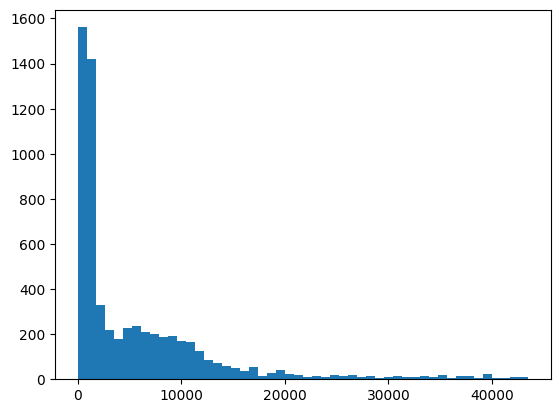

In [43]:
# Histogram of listed lot sizes with upper quartile as upper range

plt.hist(condo_lots.dropna(), bins=50, range=(1,43500))
plt.show()

In [44]:
# Looking at upper outliers

condos = data[data['propertyType'] == 'Condo']

condos[condos['lotSize'] >= 10000000.0].head(10)


,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
625,"3628-Muirfield-Ct,-New-Port-Richey,-FL-34655","3628 Muirfield Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.211985,-82.664961,Condo,2.0,...,1,1,0,1.0,1,False,1.0,None,2024-03,0.0682
15216,"3445-Niblick-Ct,-New-Port-Richey,-FL-34655","3445 Niblick Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.209507,-82.664333,Condo,2.0,...,1,1,0,1.0,1,False,1.0,None,2024-03,0.0682
20123,"5973-Terrace-Park-Dr-N,-Unit-209,-Saint-Peters...","5973 Terrace Park Dr N, Unit 209, Saint Peters...",Saint Petersburg,FL,33709,Pinellas,27.826396,-82.746076,Condo,2.0,...,1,1,0,1.0,1,False,1.0,Average,2024-04,0.0699
29161,"3734-River-Oaks-Ct,-New-Port-Richey,-FL-34655","3734 River Oaks Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.213333,-82.665034,Condo,2.0,...,1,1,0,1.0,1,False,1.0,None,2024-04,0.0699
32126,"271-Sapphire-Lake-Dr,-Unit-101,-Bradenton,-FL-...","271 Sapphire Lake Dr, Unit 101, Bradenton, FL ...",Bradenton,FL,34209,Manatee,27.504514,-82.682463,Condo,3.0,...,1,1,0,1.0,1,False,1.0,None,2024-04,0.0699
38623,"3654-Trophy-Blvd,-New-Port-Richey,-FL-34655","3654 Trophy Blvd, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.212197,-82.656730,Condo,2.0,...,1,1,0,1.0,1,0,1.0,None,2024-04,0.0699
39517,"9617-Midiron-Ct,-New-Port-Richey,-FL-34655","9617 Midiron Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.214868,-82.655253,Condo,2.0,...,1,1,0,1.0,1,0,1.0,None,2024-04,0.0699
42694,"3650-Trophy-Blvd,-New-Port-Richey,-FL-34655","3650 Trophy Blvd, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.211634,-82.656533,Condo,2.0,...,1,1,0,1.0,1,0,1.0,None,2024-04,0.0699
47683,"3444-Teeside-Dr,-New-Port-Richey,-FL-34655","3444 Teeside Dr, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.209467,-82.653406,Condo,2.0,...,1,1,0,1.0,1,0,1.0,None,2024-04,0.0699
60341,"3523-Teeside-Dr,-New-Port-Richey,-FL-34655","3523 Teeside Dr, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.210440,-82.654263,Condo,2.0,...,1,1,0,1.0,1,False,1.0,None,2024-05,0.0760


Many of these condos with large lot sizes appear to have attached golf courses, but golf course is not stated in viewType (there are a number of different ways to indicate golf course in that column). 

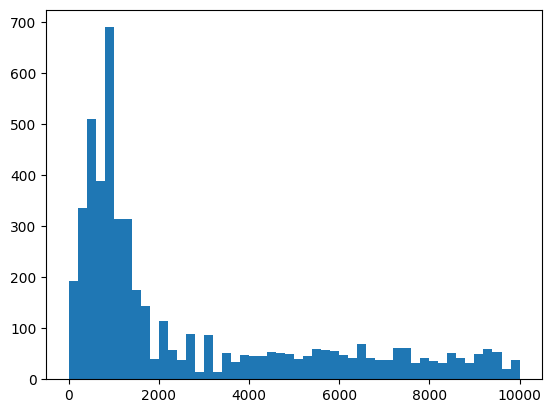

In [45]:
# Looking at lower range--under 10,000

plt.hist(condo_lots.dropna(), bins=50, range=(1,10000))
plt.show()

In [46]:
len(condos[condos['lotSize'] < 10000])

15322

In [47]:
condos[condos['lotSize'] == 1].head(10)

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
13581,"8247-Nw-108th-Ct,-Unit-2,-Doral,-FL-33178","8247 Nw 108th Ct, Unit 2, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849528,-80.371886,Condo,3.0,...,0,0,0,2.0,0,False,1.0,None,2024-03,0.0682
16593,"8432-Nw-107th-Ct,-Unit-11,-Doral,-FL-33178","8432 Nw 107th Ct, Unit 11, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849533,-80.371880,Condo,4.0,...,0,0,0,2.0,0,False,1.0,None,2024-03,0.0682
34603,"607-Verrocchio-Dr,-Nokomis,-FL-34275","607 Verrocchio Dr, Nokomis, FL 34275",Nokomis,FL,34275,Sarasota,27.165702,-82.468757,Condo,2.0,...,1,1,0,1.0,1,0,1.0,Water,2024-04,0.0699
41854,"523-Pine-Hollow-Cir,-Englewood,-FL-34223","523 Pine Hollow Cir, Englewood, FL 34223",Englewood,FL,34223,Sarasota,26.959838,-82.349775,Condo,2.0,...,1,1,0,1.0,1,0,1.0,Lake,2024-04,0.0699
42018,"1600-Sw-1st-Ave,-Apt-706,-Miami,-FL-33129","1600 Sw 1st Ave, Apt 706, Miami, FL 33129",Miami,FL,33129,Miami-Dade,25.759377,-80.197548,Condo,1.0,...,0,0,0,1.0,0,0,1.0,None,2024-04,0.0699
43684,"10775-Nw-83rd-Ter,-Unit-1,-Doral,-FL-33178","10775 Nw 83rd Ter, Unit 1, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849533,-80.371880,Condo,4.0,...,0,0,0,2.0,0,0,1.0,None,2024-04,0.0699
46242,"1100-S-Miami-Ave,-Apt-3904,-Miami,-FL-33130","1100 S Miami Ave, Apt 3904, Miami, FL 33130",Miami,FL,33130,Miami-Dade,25.763216,-80.193663,Condo,2.0,...,0,0,0,1.0,0,0,1.0,None,2024-04,0.0699
54145,"8244-Nw-107th-Path,-Unit-10,-Doral,-FL-33178","8244 Nw 107th Path, Unit 10, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849533,-80.371880,Condo,2.0,...,0,0,0,2.0,0,False,1.0,None,2024-05,0.0760
69451,"8501-Nw-107th-Ct,-Unit-3,-Doral,-FL-33178","8501 Nw 107th Ct, Unit 3, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849533,-80.371880,Condo,2.0,...,0,0,0,2.0,0,False,1.0,None,2024-05,0.0760
72192,"8301-Nw-107th-Ct,-Unit-6,-Doral,-FL-33178","8301 Nw 107th Ct, Unit 6, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849533,-80.371880,Condo,3.0,...,0,0,0,2.0,0,False,1.0,None,2024-05,0.0760


Dealing with lot size for condos--initial idea:
- With viewType column, simplify all titles with golf in the name to one value
- Search the subdivision column for the word golf and use it to alter the viewType column
- Drop large lot size values that don't have the word golf
- For properties without golf, assign the mean of the lower quartile to all lot sizes

In [48]:
data['viewType'].value_counts()

viewType
Water                                              2253
Average                                            1599
Golf Course                                         569
Lake                                                283
Park                                                138
River                                                80
Lake / Pond                                          34
Canal                                                14
City                                                 10
Creek / Lake                                          9
Lake, Corner                                          9
Fairway                                               8
Golf Course, Lake                                     7
Waterfront / Beach, Corner                            7
Golf Course, Corner                                   6
Waterfront / Canal, Corner                            3
Historical                                            3
Waterfront / Beach, Golf Course        

In [49]:
# Creating a binary golf column

golf_mapper = {
    'Golf Course':1,
    'Golf Course, Lake':1,
    'Golf Course, Corner':1,
    'Golf Course, Waterfront / Beach':1,
    'Lake, Golf Course':1
}

data['golf'] = data['viewType'].map(golf_mapper).fillna(0).astype(int)

In [50]:
data['golf'].value_counts()

golf
0    114299
1       584
Name: count, dtype: int64

In [51]:
data[data['subdivision'].str.contains('GOLF', case=False, na=False)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf
142,"210-Hazard-St,-Orlando,-FL-32804","210 Hazard St, Orlando, FL 32804",Orlando,FL,32804,Orange,28.587267,-81.380476,Single Family,2.0,...,1,0,1.0,1,False,1.0,None,2024-03,0.0682,0
204,"5820-Nw-12th-St,-Apt-D,-Sunrise,-FL-33313","5820 Nw 12th St, Apt D, Sunrise, FL 33313",Sunrise,FL,33313,Broward,26.138610,-80.228350,Single Family,3.0,...,0,0,1.0,0,False,1.0,None,2024-03,0.0682,0
207,"6680-Nw-29th-Ct,-Sunrise,-FL-33313","6680 Nw 29th Ct, Sunrise, FL 33313",Sunrise,FL,33313,Broward,26.162295,-80.238154,Single Family,2.0,...,0,0,1.0,1,False,1.0,None,2024-03,0.0682,0
232,"8608-Se-141st-Street-Rd,-Summerfield,-FL-34491","8608 Se 141st Street Rd, Summerfield, FL 34491",Summerfield,FL,34491,Marion,29.018361,-82.010480,Single Family,2.0,...,1,0,1.0,1,False,1.0,None,2024-03,0.0682,0
242,"3189-Pebble-Beach-Dr,-Lake-Worth,-FL-33467","3189 Pebble Beach Dr, Lake Worth, FL 33467",Lake Worth,FL,33467,Palm Beach,26.629463,-80.173028,Single Family,3.0,...,1,0,1.0,0,True,1.0,None,2024-03,0.0682,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144783,"350-Club-Cir,-Apt-207,-Boca-Raton,-FL-33487","350 Club Cir, Apt 207, Boca Raton, FL 33487",Boca Raton,FL,33487,Palm Beach,26.395432,-80.085060,Condo,2.0,...,0,0,1.0,0,False,1.0,None,2024-06,0.0692,0
144899,"836-Blue-Crane-Dr,-Venice,-FL-34285","836 Blue Crane Dr, Venice, FL 34285",Venice,FL,34285,Sarasota,27.083954,-82.412983,Single Family,3.0,...,1,1,1.0,1,False,1.0,None,2024-06,0.0692,0
145021,"3801-Michaels-Landing-Cir-E,-Jacksonville,-FL-...","3801 Michaels Landing Cir E, Jacksonville, FL ...",Jacksonville,FL,32224,Duval,30.279827,-81.486056,Single Family,4.0,...,1,1,2.0,1,False,1.0,None,2024-06,0.0692,0
145153,"4665-Bocaire-Blvd,-Boca-Raton,-FL-33487","4665 Bocaire Blvd, Boca Raton, FL 33487",Boca Raton,FL,33487,Palm Beach,26.419460,-80.115809,Single Family,3.0,...,1,0,1.0,1,True,1.0,Golf Course,2024-06,0.0692,1


In [52]:
data.loc[data['subdivision'].str.contains('GOLF', case=False, na=False), 'golf'] = 1
data['golf'].value_counts()

golf
0    113337
1      1546
Name: count, dtype: int64

In [53]:
data[data['golf'] == 1] 

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf
142,"210-Hazard-St,-Orlando,-FL-32804","210 Hazard St, Orlando, FL 32804",Orlando,FL,32804,Orange,28.587267,-81.380476,Single Family,2.0,...,1,0,1.0,1,False,1.0,None,2024-03,0.0682,1
204,"5820-Nw-12th-St,-Apt-D,-Sunrise,-FL-33313","5820 Nw 12th St, Apt D, Sunrise, FL 33313",Sunrise,FL,33313,Broward,26.138610,-80.228350,Single Family,3.0,...,0,0,1.0,0,False,1.0,None,2024-03,0.0682,1
207,"6680-Nw-29th-Ct,-Sunrise,-FL-33313","6680 Nw 29th Ct, Sunrise, FL 33313",Sunrise,FL,33313,Broward,26.162295,-80.238154,Single Family,2.0,...,0,0,1.0,1,False,1.0,None,2024-03,0.0682,1
232,"8608-Se-141st-Street-Rd,-Summerfield,-FL-34491","8608 Se 141st Street Rd, Summerfield, FL 34491",Summerfield,FL,34491,Marion,29.018361,-82.010480,Single Family,2.0,...,1,0,1.0,1,False,1.0,None,2024-03,0.0682,1
242,"3189-Pebble-Beach-Dr,-Lake-Worth,-FL-33467","3189 Pebble Beach Dr, Lake Worth, FL 33467",Lake Worth,FL,33467,Palm Beach,26.629463,-80.173028,Single Family,3.0,...,1,0,1.0,0,True,1.0,None,2024-03,0.0682,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145025,"4949-Willow-Ridge-Ter,-Valrico,-FL-33596","4949 Willow Ridge Ter, Valrico, FL 33596",Valrico,FL,33596,Hillsborough,27.889401,-82.210993,Single Family,3.0,...,1,0,1.0,1,True,1.0,Golf Course,2024-06,0.0692,1
145078,"2142-Hainlin-Ct,-Deltona,-FL-32738","2142 Hainlin Ct, Deltona, FL 32738",Deltona,FL,32738,Volusia,28.923445,-81.199121,Single Family,3.0,...,1,1,1.0,1,False,1.0,Golf Course,2024-06,0.0692,1
145153,"4665-Bocaire-Blvd,-Boca-Raton,-FL-33487","4665 Bocaire Blvd, Boca Raton, FL 33487",Boca Raton,FL,33487,Palm Beach,26.419460,-80.115809,Single Family,3.0,...,1,0,1.0,1,True,1.0,Golf Course,2024-06,0.0692,1
145157,"7271-Golf-Pointe-Way,-Sarasota,-FL-34243","7271 Golf Pointe Way, Sarasota, FL 34243",Sarasota,FL,34243,Manatee,27.407698,-82.490084,Condo,2.0,...,1,0,1.0,1,False,1.0,None,2024-06,0.0692,1


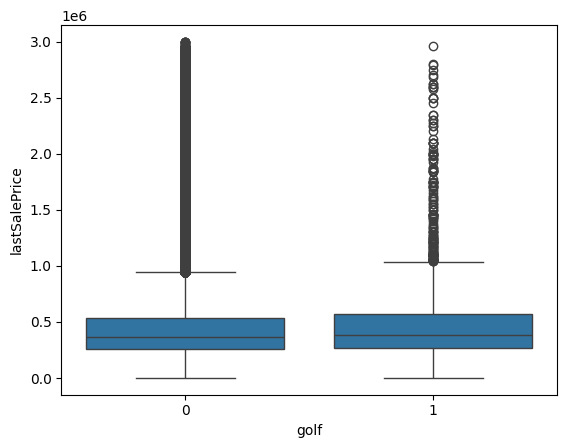

In [54]:
# Visualizing golf and price

sns.boxplot(data=data, x='golf', y='lastSalePrice')
plt.show()

Conclusions:
- few properties with golf
- noisy data in this area
- unclear relationships

Next step: Does lot size correlate with price for condos? It may make sense to take lot size out of the equation for condos.

In [55]:
condos.shape

(20955, 27)

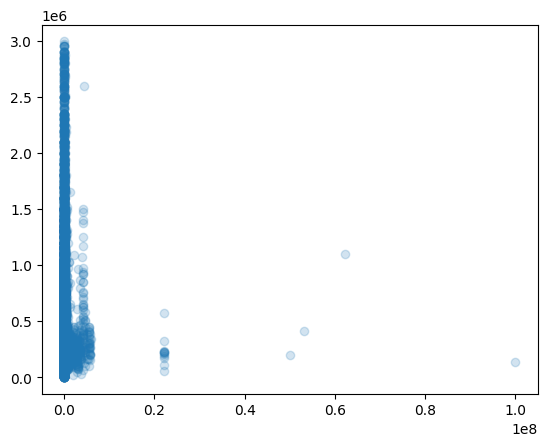

In [56]:
plt.scatter(x=condos['lotSize'], y=condos['lastSalePrice'], alpha=0.2)
plt.show()

In [57]:
# Investigating a few large lots on Zillow/Google

condos[condos['lotSize'] > 20000000].head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate
625,"3628-Muirfield-Ct,-New-Port-Richey,-FL-34655","3628 Muirfield Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.211985,-82.664961,Condo,2.0,...,1,1,0,1.0,1,False,1.0,None,2024-03,0.0682
15216,"3445-Niblick-Ct,-New-Port-Richey,-FL-34655","3445 Niblick Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.209507,-82.664333,Condo,2.0,...,1,1,0,1.0,1,False,1.0,None,2024-03,0.0682
20123,"5973-Terrace-Park-Dr-N,-Unit-209,-Saint-Peters...","5973 Terrace Park Dr N, Unit 209, Saint Peters...",Saint Petersburg,FL,33709,Pinellas,27.826396,-82.746076,Condo,2.0,...,1,1,0,1.0,1,False,1.0,Average,2024-04,0.0699
29161,"3734-River-Oaks-Ct,-New-Port-Richey,-FL-34655","3734 River Oaks Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.213333,-82.665034,Condo,2.0,...,1,1,0,1.0,1,False,1.0,None,2024-04,0.0699
32126,"271-Sapphire-Lake-Dr,-Unit-101,-Bradenton,-FL-...","271 Sapphire Lake Dr, Unit 101, Bradenton, FL ...",Bradenton,FL,34209,Manatee,27.504514,-82.682463,Condo,3.0,...,1,1,0,1.0,1,False,1.0,None,2024-04,0.0699


There is no apparent correlation: some of these are clearly next to golf courses, but two are not. It might make the most sense to make lot size 0 and trust the location data to account for the price differences.

In [58]:
# Assigning 0 to lotSize for all condos

data.loc[data["propertyType"] == "Condo", "lotSize"] = 0

In [59]:
# Looking at lot size for single family homes

single_family = data[data['propertyType'] == 'Single Family']
single_family.shape

(89253, 28)

count    8.925300e+04
mean     3.031518e+04
std      2.721439e+06
min      1.000000e+00
25%      6.000000e+03
50%      8.219000e+03
75%      1.083200e+04
max      6.000000e+08
Name: lotSize, dtype: float64


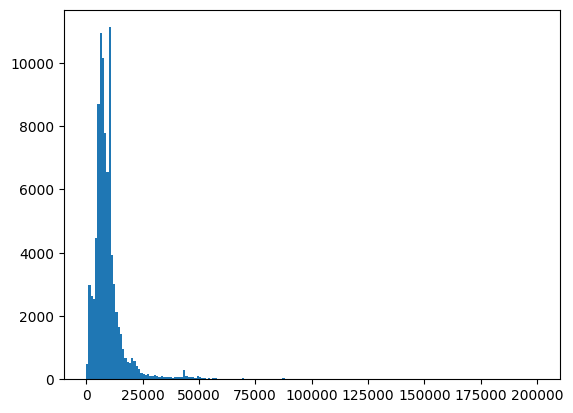

In [60]:
# Distribution of lot size for single family

print(single_family['lotSize'].describe())

plt.hist(single_family['lotSize'], bins=200,range=(0, 200000))
plt.show()

In [61]:
# Considering dropping outliers for this and limiting scope of project to typical homes for average buyer

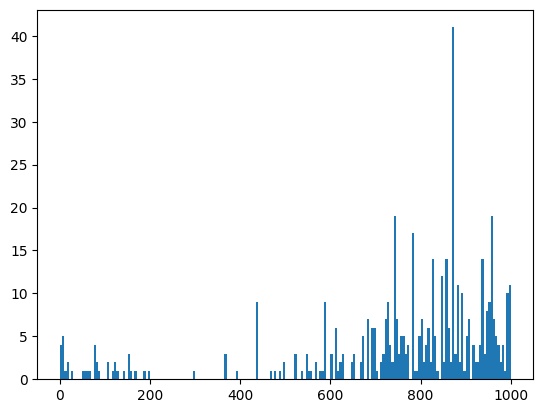

In [62]:
plt.hist(single_family['lotSize'], bins=200,range=(0, 1000))
plt.show()

In [63]:
single_family[single_family['lotSize'] == 1]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf
63374,"212-Mableberry-Ct,-Daytona-Beach,-FL-32124","212 Mableberry Ct, Daytona Beach, FL 32124",Daytona Beach,FL,32124,Volusia,29.191970,-81.125144,Single Family,4.0,...,1,0,1.0,1,False,1.0,None,2024-05,0.0760,0
98490,"1515-Lake-Dr,-Casselberry,-FL-32707","1515 Lake Dr, Casselberry, FL 32707",Casselberry,FL,32707,Seminole,28.671338,-81.303728,Single Family,2.0,...,1,0,1.0,1,0,1.0,None,2024-06,0.0692,0
113190,"373-E-Magnolia-Ave,-Longwood,-FL-32750","373 E Magnolia Ave, Longwood, FL 32750",Longwood,FL,32750,Seminole,28.702608,-81.340610,Single Family,3.0,...,1,0,1.0,1,False,1.0,None,2024-07,0.0685,0
142956,"6375-E-Anna-Jo-Dr,-Inverness,-FL-34452","6375 E Anna Jo Dr, Inverness, FL 34452",Inverness,FL,34452,Citrus,28.783939,-82.328681,Single Family,2.0,...,1,0,1.0,1,False,1.0,None,2024-06,0.0692,0


In [64]:
# These look like innacurate records--possibly lotSize was meant to be in acres

In [65]:
single_family[(single_family['lotSize'] > 400) & (single_family['lotSize'] < 500)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf
6412,"9788-Sw-99th-Ave,-Ocala,-FL-34481","9788 Sw 99th Ave, Ocala, FL 34481",Ocala,FL,34481,Marion,29.080296,-82.284426,Single Family,2.0,...,1,0,1.0,1,False,1.0,None,2024-03,0.0682,0
10958,"4024-Sw-21st-Rd,-Gainesville,-FL-32607","4024 Sw 21st Rd, Gainesville, FL 32607",Gainesville,FL,32607,Alachua,29.633516,-82.384180,Single Family,2.0,...,1,0,2.0,0,False,1.0,None,2024-03,0.0682,0
16373,"510-Fleming-St,-Key-West,-FL-33040","510 Fleming St, Key West, FL 33040",Key West,FL,33040,Monroe,24.556139,-81.802510,Single Family,0.0,...,0,0,1.0,1,False,1.0,None,2024-03,0.0682,0
38280,"2109-Sw-39th-Way,-Gainesville,-FL-32607","2109 Sw 39th Way, Gainesville, FL 32607",Gainesville,FL,32607,Alachua,29.633143,-82.383483,Single Family,2.0,...,1,0,2.0,0,0,1.0,None,2024-04,0.0699,0
58118,"3832-Sw-33rd-Ter,-Ocala,-FL-34474","3832 Sw 33rd Ter, Ocala, FL 34474",Ocala,FL,34474,Marion,29.148790,-82.177158,Single Family,3.0,...,1,0,1.0,1,False,1.0,None,2024-05,0.0760,0
89855,"3488-Nw-37th-Ave,-Gainesville,-FL-32605","3488 Nw 37th Ave, Gainesville, FL 32605",Gainesville,FL,32605,Alachua,29.688010,-82.373558,Single Family,2.0,...,1,0,1.0,0,False,1.0,None,2024-06,0.0692,0
95001,"9738-Sw-99th-Ave,-Ocala,-FL-34481","9738 Sw 99th Ave, Ocala, FL 34481",Ocala,FL,34481,Marion,29.081203,-82.284260,Single Family,2.0,...,1,0,1.0,1,False,1.0,None,2024-06,0.0692,0
97272,"2728-Lake-Mary-St,-Tallahassee,-FL-32310","2728 Lake Mary St, Tallahassee, FL 32310",Tallahassee,FL,32310,Leon,30.410801,-84.309853,Single Family,3.0,...,0,0,1.0,0,False,1.0,None,2024-06,0.0692,0
103333,"2207-Sw-39th-Way,-Gainesville,-FL-32607","2207 Sw 39th Way, Gainesville, FL 32607",Gainesville,FL,32607,Alachua,29.632214,-82.384058,Single Family,2.0,...,1,0,2.0,0,False,1.0,None,2024-07,0.0685,0
103396,"2990-Ravines-Rd,-Unit-1425,-Middleburg,-FL-32068","2990 Ravines Rd, Unit 1425, Middleburg, FL 32068",Middleburg,FL,32068,Clay,30.063752,-81.854005,Single Family,1.0,...,1,0,1.0,0,False,1.0,None,2024-07,0.0685,0


In [66]:
# These records seem very innacurate for lot size--dropping everything under 1000

data = data[data['lotSize'] >= 1000]

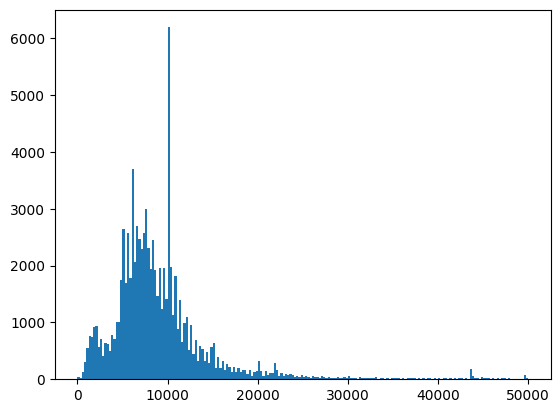

In [67]:
plt.hist(single_family['lotSize'], bins=200,range=(0, 50000))
plt.show()

In [68]:
# Filtering remaining values to under 30,000

data = data[data['lotSize'] < 30000]

# EDA on sale prices

In [69]:
data['lastSalePrice'].describe()

count    8.961400e+04
mean     4.678899e+05
std      3.558866e+05
min      3.100000e+02
25%      2.800000e+05
50%      3.800000e+05
75%      5.400000e+05
max      2.998200e+06
Name: lastSalePrice, dtype: float64

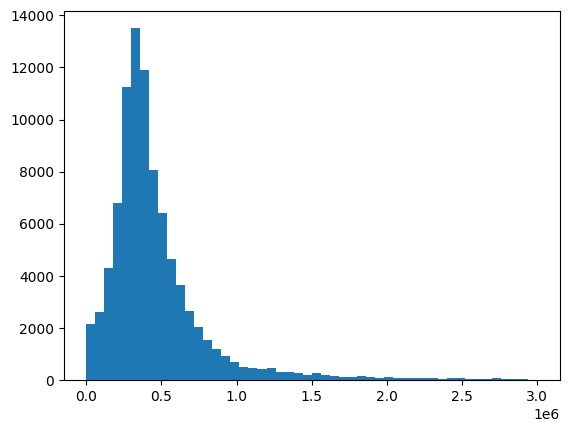

In [70]:
plt.hist(data['lastSalePrice'], bins=50)
plt.show()

In [71]:
# Low end of price

data[data['lastSalePrice'] < 1000].head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf
846,"347-Tierra-Verde-Way,-Bradenton,-FL-34212","347 Tierra Verde Way, Bradenton, FL 34212",Bradenton,FL,34212,Manatee,27.501787,-82.390296,Single Family,5.0,...,1,0,2.0,1,False,1.0,None,2024-03,0.0682,0
1354,"1941-Oakland-Park-Dr,-Lake-Wales,-FL-33898","1941 Oakland Park Dr, Lake Wales, FL 33898",Lake Wales,FL,33898,Polk,27.909630,-81.557569,Single Family,3.0,...,0,0,1.0,1,False,1.0,None,2024-03,0.0682,0
1523,"7322-Sea-Grape-Ave,-Port-Richey,-FL-34668","7322 Sea Grape Ave, Port Richey, FL 34668",Port Richey,FL,34668,Pasco,28.312594,-82.693358,Single Family,2.0,...,1,0,1.0,1,False,1.0,None,2024-03,0.0682,0
3783,"12404-Shawnee-Trl,-Largo,-FL-33774","12404 Shawnee Trl, Largo, FL 33774",Largo,FL,33774,Pinellas,27.885332,-82.835326,Single Family,3.0,...,1,1,1.0,1,False,1.0,None,2024-03,0.0682,0
8699,"6045-Lace-Wood-Cir,-Lake-Worth,-FL-33462","6045 Lace Wood Cir, Lake Worth, FL 33462",Lake Worth,FL,33462,Palm Beach,26.587840,-80.109210,Single Family,2.0,...,1,0,2.0,1,False,1.0,None,2024-03,0.0682,0


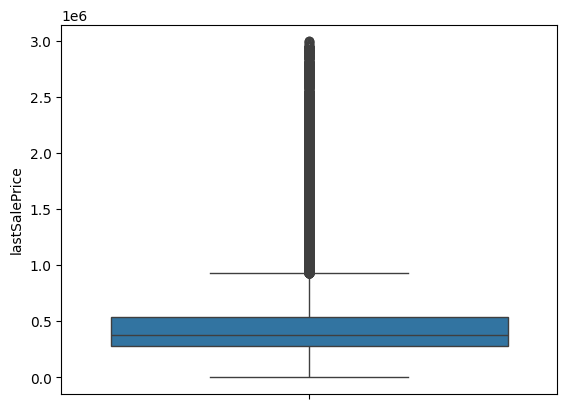

In [72]:
# These are all innacurate--need to filter the remaining prices

sns.boxplot(data['lastSalePrice'])
plt.show()

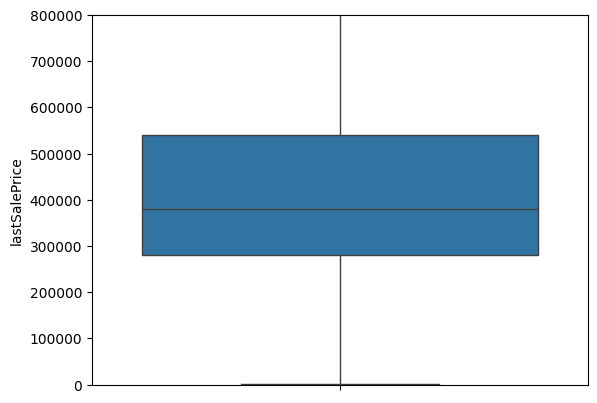

In [73]:
sns.boxplot(data['lastSalePrice'])
plt.ylim(0, 800_000)

plt.show()

In [74]:
data['lastSalePrice'].describe()

count    8.961400e+04
mean     4.678899e+05
std      3.558866e+05
min      3.100000e+02
25%      2.800000e+05
50%      3.800000e+05
75%      5.400000e+05
max      2.998200e+06
Name: lastSalePrice, dtype: float64

# EDA on unitCount

In [75]:
data['unitCount'].describe()

count    89614.000000
mean         1.004296
std          0.306444
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         90.000000
Name: unitCount, dtype: float64

Massive range of values, but the majority of properties are single unit.

# more EDA on propertyType

In [76]:
data['propertyType'].value_counts()

propertyType
Single Family    85662
Manufactured      2772
Townhouse         1180
Name: count, dtype: int64

Most properties are condo or single family.

In [77]:
# Looking at propertyType --> Manufactured

manufactured = data[data['propertyType'] == 'Manufactured']
manufactured.shape

(2772, 28)

In [78]:
manufactured.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,m_rate,golf
count,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2.772000e+03,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000
mean,28.040479,-81.914820,2.326479,1.776515,1094.589827,8299.196248,1985.883117,1.623022e+05,0.751082,0.738817,0.054834,1.002525,0.641775,1.001443,0.070372,0.012987
std,1.158497,1.064831,0.668283,0.442183,380.864218,5636.870298,14.089190,1.072713e+05,0.432464,0.439359,0.227697,0.050197,0.479565,0.037966,0.003323,0.113239
min,24.566139,-87.510107,1.000000,1.000000,200.000000,1110.000000,1900.000000,6.000000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.061800,0.000000
25%,27.221167,-82.349400,2.000000,1.500000,828.000000,4507.000000,1975.000000,9.900000e+04,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.068500,0.000000
50%,28.111328,-81.938335,2.000000,2.000000,1065.500000,6142.000000,1985.000000,1.500000e+05,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.069200,0.000000
75%,28.846889,-81.501319,3.000000,2.000000,1344.000000,10019.000000,1994.000000,2.000000e+05,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.069900,0.000000
max,30.816975,-80.060530,6.000000,4.000000,3209.000000,29621.000000,2025.000000,1.550000e+06,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,0.076000,1.000000


In [79]:
# It looks like this is mostly single units, but the max is 5,000 for units

manufactured['unitCount'].value_counts()

unitCount
1.0    2768
2.0       4
Name: count, dtype: int64

In [80]:
# Looking at the outlier

manufactured[manufactured['unitCount'] == 5000]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf


From checking Zillow on this address, this is an entire condo complex--probably outside the scope of the project.

What are the single-unit properties in this category like?

In [81]:
manufactured = manufactured[manufactured['unitCount'] == 1.0]
manufactured.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf
67,"8709-S-Meadowview-Cir,-Tampa,-FL-33625","8709 S Meadowview Cir, Tampa, FL 33625",Tampa,FL,33625,Hillsborough,28.053556,-82.577342,Manufactured,2.0,...,1,0,1.0,1,False,1.0,None,2024-03,0.0682,0
97,"3141-Old-Farm-House-Dr,-North-Fort-Myers,-FL-3...","3141 Old Farm House Dr, North Fort Myers, FL 3...",North Fort Myers,FL,33917,Lee,26.709915,-81.895790,Manufactured,2.0,...,1,0,1.0,1,False,1.0,None,2024-03,0.0682,0
98,"128-Torch-Ln,-North-Fort-Myers,-FL-33917","128 Torch Ln, North Fort Myers, FL 33917",North Fort Myers,FL,33917,Lee,26.692646,-81.859562,Manufactured,2.0,...,1,0,1.0,1,False,1.0,None,2024-03,0.0682,0
137,"16-Golden-Gate-Cir,-Port-Orange,-FL-32129","16 Golden Gate Cir, Port Orange, FL 32129",Port Orange,FL,32129,Volusia,29.136491,-81.017564,Manufactured,3.0,...,1,1,1.0,1,False,1.0,None,2024-03,0.0682,0
323,"207-E-Harris-St,-Palatka,-FL-32177","207 E Harris St, Palatka, FL 32177",Palatka,FL,32177,Putnam,29.660439,-81.653605,Manufactured,3.0,...,0,0,1.0,0,False,1.0,None,2024-03,0.0682,0


Looking at some of these on Zillow, they seem to be mostly mobile homes with a few single family homes mixed in. 

This category may be fine for the model.

# EDA on multiFamily

In [82]:
multiFamily = data[data['propertyType'] == 'Multi-Family']
multiFamily.shape

(0, 28)

In [83]:
multiFamily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                0 non-null      object             
 1   formattedAddress  0 non-null      object             
 2   city              0 non-null      object             
 3   state             0 non-null      object             
 4   zipCode           0 non-null      object             
 5   county            0 non-null      object             
 6   latitude          0 non-null      float64            
 7   longitude         0 non-null      float64            
 8   propertyType      0 non-null      object             
 9   bedrooms          0 non-null      float64            
 10  bathrooms         0 non-null      float64            
 11  squareFootage     0 non-null      float64            
 12  lotSize           0 non-null      float64            
 13  yearBuilt         0 no

In [84]:
# Looking at range of sale values

# plt.scatter(x=multiFamily.id, y=multiFamily.lastSalePrice)
# plt.show()

In [85]:
# What are the 100000000+ million dollar places, and the other outliers over 20,000,000?

multiFamily[multiFamily.lastSalePrice > 20000000]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf


From Zillow research, these seem to be either large apartment buildings or innacurate records.

In [86]:
# Looking at the 10 to 20 million range

multiFamily[(multiFamily.lastSalePrice < 20000000) & (multiFamily.lastSalePrice > 10000000)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf


There is a combination of full apartment buildings and individual units. 

Recommend dropping this category--outside of the scope of a web app for home buyers and likely to misinform the model.

# EDA on Townhouse

In [87]:
townhouse = data[data['propertyType'] == 'Townhouse']
townhouse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1180 entries, 1 to 145450
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                1180 non-null   object             
 1   formattedAddress  1180 non-null   object             
 2   city              1180 non-null   object             
 3   state             1180 non-null   object             
 4   zipCode           1180 non-null   object             
 5   county            1175 non-null   object             
 6   latitude          1180 non-null   float64            
 7   longitude         1180 non-null   float64            
 8   propertyType      1180 non-null   object             
 9   bedrooms          1180 non-null   float64            
 10  bathrooms         1180 non-null   float64            
 11  squareFootage     1180 non-null   float64            
 12  lotSize           1180 non-null   float64            
 13  yearBu

In [88]:
townhouse.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,m_rate,golf
count,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1.180000e+03,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000
mean,27.927345,-81.601409,2.800847,2.428390,1607.968644,3128.300000,2006.408475,4.601986e+05,0.394068,0.358475,0.042373,1.401695,0.360169,1.093220,0.068290,0.002542
std,1.455549,1.472322,0.640848,0.565625,617.194888,2548.142966,17.769973,4.046886e+05,0.488857,0.479756,0.201524,0.538270,0.480253,2.605492,0.003517,0.050379
min,24.576702,-87.444341,1.000000,1.000000,606.000000,1000.000000,1900.000000,4.100000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.061800,0.000000
25%,26.591706,-82.222583,2.000000,2.000000,1337.500000,1760.000000,1989.000000,2.594500e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.067200,0.000000
50%,28.139506,-81.488735,3.000000,2.500000,1565.000000,2249.000000,2010.000000,3.441500e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.068400,0.000000
75%,28.598730,-80.376878,3.000000,2.500000,1790.000000,3485.000000,2024.000000,4.750000e+05,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.069600,0.000000
max,30.956392,-80.050755,6.000000,9.000000,16783.000000,27000.000000,2026.000000,2.946539e+06,1.000000,1.000000,1.000000,4.000000,1.000000,90.000000,0.076000,1.000000


Nothing here seems too unusual, aside from max yearBuilt is 2026--will investigate that whole column. This category may be fine to use.

# EDA on yearBuilt

In [89]:
data['yearBuilt'].info()

<class 'pandas.core.series.Series'>
Index: 89614 entries, 1 to 145616
Series name: yearBuilt
Non-Null Count  Dtype  
--------------  -----  
89614 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [90]:
data['yearBuilt'].describe()

count    89614.000000
mean      1991.100475
std         25.624238
min        202.000000
25%       1973.000000
50%       1993.000000
75%       2013.000000
max       2028.000000
Name: yearBuilt, dtype: float64

In [91]:
# The min is 202--investigating further

data[data['yearBuilt'] == 202]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf
121788,"4451-Sw-170th-Street-Rd,-Ocala,-FL-34473","4451 Sw 170th Street Rd, Ocala, FL 34473",Ocala,FL,34473,Marion,28.974421,-82.195729,Single Family,3.0,...,0,0,1.0,0,False,1.0,None,2024-07,0.0685,0


In [92]:
# Filling in year from Zillow

data.loc[121788, 'yearBuilt'] = 2023

In [93]:
# Properties with year built in future

data[(data['yearBuilt'] >= 2026) & (data['yearBuilt'] <= 2028)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf
267,"145-Nw-9th-St,-Boca-Raton,-FL-33432","145 Nw 9th St, Boca Raton, FL 33432",Boca Raton,FL,33432,Palm Beach,26.358732,-80.088873,Single Family,5.0,...,1,0,1.0,1,False,1.0,None,2024-03,0.0682,0
14045,"303-N-Riverside-Dr,-Indialantic,-FL-32903","303 N Riverside Dr, Indialantic, FL 32903",Indialantic,FL,32903,Brevard,28.090759,-80.575606,Townhouse,3.0,...,1,1,1.0,1,False,1.0,None,2024-03,0.0682,0
46028,"939-Eve-St,-Delray-Beach,-FL-33483","939 Eve St, Delray Beach, FL 33483",Delray Beach,FL,33483,Palm Beach,26.438058,-80.067800,Single Family,6.0,...,1,0,1.0,1,1,1.0,Water,2024-04,0.0699,0
55187,"910-N-Venetian-Dr,-Miami-Beach,-FL-33139","910 N Venetian Dr, Miami Beach, FL 33139",Miami Beach,FL,33139,Miami-Dade,25.790402,-80.176450,Single Family,5.0,...,0,0,1.0,0,False,1.0,None,2024-05,0.0760,0
98992,"3929-Belmont-St,-Fort-Myers,-FL-33916","3929 Belmont St, Fort Myers, FL 33916",Fort Myers,FL,33916,Lee,26.657848,-81.833645,Single Family,4.0,...,0,0,1.0,0,0,1.0,None,2024-06,0.0692,0
125767,"2267-Windsor-Rd,-Palm-Beach-Gardens,-FL-33410","2267 Windsor Rd, Palm Beach Gardens, FL 33410",Palm Beach Gardens,FL,33410,Palm Beach,26.870753,-80.067382,Single Family,5.0,...,0,0,1.0,0,False,1.0,None,2024-08,0.0650,0
126074,"Eve-Cir,-Santa-Rosa-Beach,-FL-32459","Eve Cir, Santa Rosa Beach, FL 32459",Santa Rosa Beach,FL,32459,Walton,30.371818,-86.108500,Single Family,5.0,...,0,0,1.0,0,False,1.0,None,2024-08,0.0650,0
126126,"409-Palm-Trl,-Delray-Beach,-FL-33483","409 Palm Trl, Delray Beach, FL 33483",Delray Beach,FL,33483,Palm Beach,26.469672,-80.063892,Single Family,4.0,...,1,0,2.0,1,True,1.0,None,2024-08,0.0650,0
126907,"801-Bond-Way,-Delray-Beach,-FL-33483","801 Bond Way, Delray Beach, FL 33483",Delray Beach,FL,33483,Palm Beach,26.477563,-80.065090,Townhouse,4.0,...,1,0,1.0,1,True,2.0,None,2024-08,0.0650,0
128610,"1516-S-Orange-Ave,-Sarasota,-FL-34239","1516 S Orange Ave, Sarasota, FL 34239",Sarasota,FL,34239,Sarasota,27.319669,-82.538184,Single Family,4.0,...,1,1,1.0,1,False,1.0,None,2024-09,0.0618,0


These appear to be projected builds. Leaving these rows seems fine.

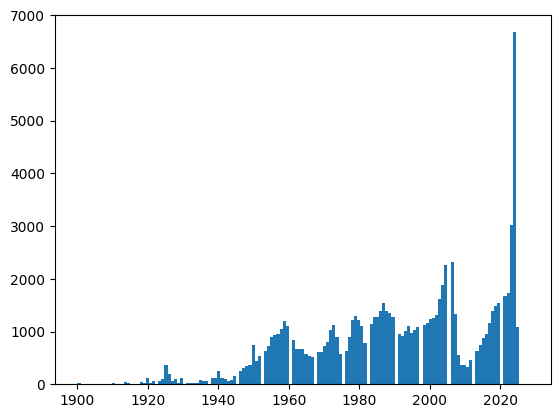

In [94]:
plt.hist(data['yearBuilt'], bins=145, range=(1900, 2028))
plt.show()

In [95]:
# Dropping values below 1920 (this improved the XGBoost by a few points)

data = data[data['yearBuilt'] > 1920]

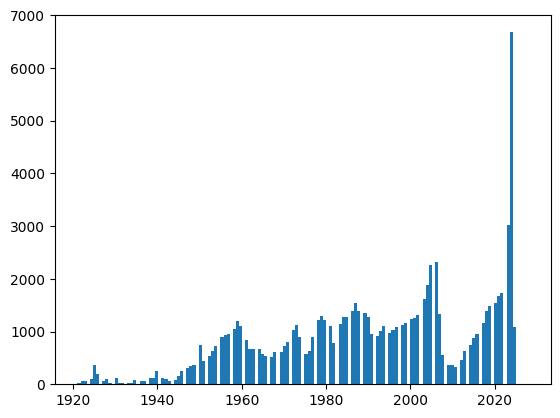

In [96]:
plt.hist(data['yearBuilt'], bins=145)
plt.show()

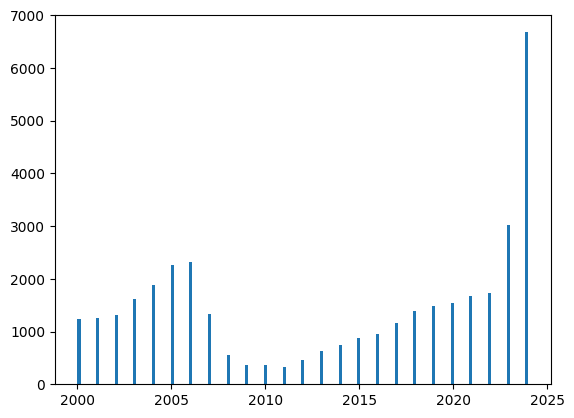

In [97]:
plt.hist(data['yearBuilt'], bins=145, range=(2000,2024))
plt.show()

A few from the 19th C, some from first half 20th, most from 2024. 

In [98]:
# Bedrooms

len(data['bedrooms']. value_counts())

16

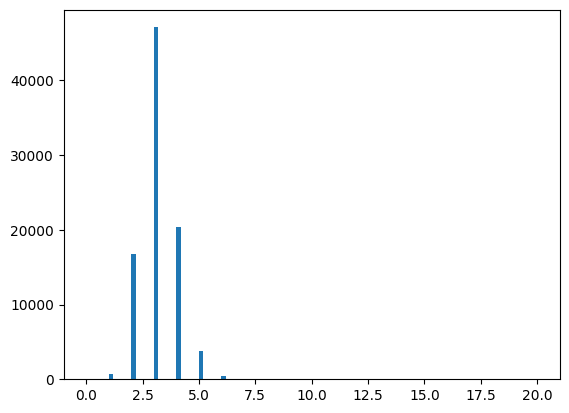

In [99]:
plt.hist(data['bedrooms'], bins=100, range=(0, 20))
plt.show()

In [100]:
# # Limiting to 10 bedrooms max

# data = data[data['bedrooms'] <= 10]

# EDA on pool

In [101]:
data['pool'].value_counts()

pool
False           65258
0               13730
True             8577
1                1642
Type Unknown        8
Inground            6
Pool/spa            1
Name: count, dtype: int64

In [102]:
data[data['pool'] == 'Type Unknown']

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,year_month,m_rate,golf
11307,"1221-Biarritz-Dr,-Miami-Beach,-FL-33141","1221 Biarritz Dr, Miami Beach, FL 33141",Miami Beach,FL,33141,Miami-Dade,25.853754,-80.132029,Single Family,4.0,...,0,0,1.0,0,Type Unknown,1.0,None,2024-03,0.0682,0
21209,"358-Ne-Genesee-Ave,-Port-Saint-Lucie,-FL-34983","358 Ne Genesee Ave, Port Saint Lucie, FL 34983",Port Saint Lucie,FL,34983,St. Lucie,27.335812,-80.341880,Single Family,3.0,...,1,0,1.0,1,Type Unknown,1.0,None,2024-04,0.0699,0
32705,"3012-Brougham-Ave,-Jacksonville,-FL-32246","3012 Brougham Ave, Jacksonville, FL 32246",Jacksonville,FL,32246,Duval,30.291696,-81.464783,Single Family,3.0,...,1,0,1.0,1,Type Unknown,1.0,None,2024-04,0.0699,0
57747,"1767-Oak-Pond-Ct,-Oldsmar,-FL-34677","1767 Oak Pond Ct, Oldsmar, FL 34677",Oldsmar,FL,34677,Pinellas,28.038162,-82.687592,Single Family,4.0,...,1,0,2.0,1,Type Unknown,1.0,None,2024-05,0.0760,0
61879,"3761-Sw-1st-St,-Fort-Lauderdale,-FL-33312","3761 Sw 1st St, Fort Lauderdale, FL 33312",Fort Lauderdale,FL,33312,Broward,26.119984,-80.198751,Single Family,4.0,...,0,0,1.0,0,Type Unknown,1.0,None,2024-05,0.0760,0
81257,"721-Ne-137th-St,-North-Miami,-FL-33161","721 Ne 137th St, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.901596,-80.184257,Single Family,3.0,...,0,0,1.0,0,Type Unknown,1.0,None,2024-05,0.0760,0
103662,"7907-11th-Ave-NW,-Bradenton,-FL-34209","7907 11th Ave NW, Bradenton, FL 34209",Bradenton,FL,34209,Manatee,27.509208,-82.641532,Single Family,3.0,...,1,1,1.0,1,Type Unknown,1.0,None,2024-07,0.0685,0
121900,"810-Se-5th-Ter,-Pompano-Beach,-FL-33060","810 Se 5th Ter, Pompano Beach, FL 33060",Pompano Beach,FL,33060,Broward,26.219815,-80.114229,Single Family,3.0,...,0,0,1.0,1,Type Unknown,1.0,None,2024-07,0.0685,0


In [103]:
# Checked on Zillow/Google for pools in the Type Unknown category--all but one have pools. Assigning 0 to that one.

data.loc[18186, 'pool'] = 0

In [104]:
data.iloc[18186]

id                  9836-Bubbling-Brook-Ct,-Oviedo,-FL-32765
formattedAddress    9836 Bubbling Brook Ct, Oviedo, FL 32765
city                                                  Oviedo
state                                                     FL
zipCode                                                32765
county                                              Seminole
latitude                                           28.615297
longitude                                         -81.244976
propertyType                                   Single Family
bedrooms                                                 3.0
bathrooms                                                2.0
squareFootage                                         1219.0
lotSize                                               3910.0
yearBuilt                                             1991.0
subdivision                                       ALOMA BEND
lastSaleDate                       2024-04-10 00:00:00+00:00
lastSalePrice           

In [105]:
# Changing the multiple ways to designate pool into 1/0

bool_mapper = {
    '1':1,
    '0':0,
    'True':1,
    'False':0,
    'Inground':1,
    'Type Unknown': 1,
    'Pool/spa':1
}

data['pool'] = data['pool'].map(bool_mapper).fillna(0).astype(int)

In [106]:
data['pool'].head()

1    1
2    0
5    1
6    0
8    0
Name: pool, dtype: int64

In [107]:
data['pool'].isna().any()

np.False_

In [108]:
# Choosing Miami, how does having a pool relate to sale price? 

miami = data[data['city'] == 'Miami']
miami.shape

(2532, 28)

In [109]:
miami['pool'].value_counts()

pool
0    2341
1     191
Name: count, dtype: int64

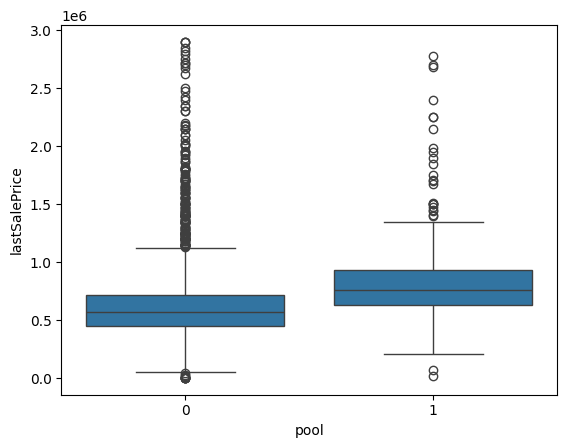

In [110]:
# Visualzing effect of pool on price in Miami

sns.boxplot(data=miami, x='pool', y='lastSalePrice')
plt.show()

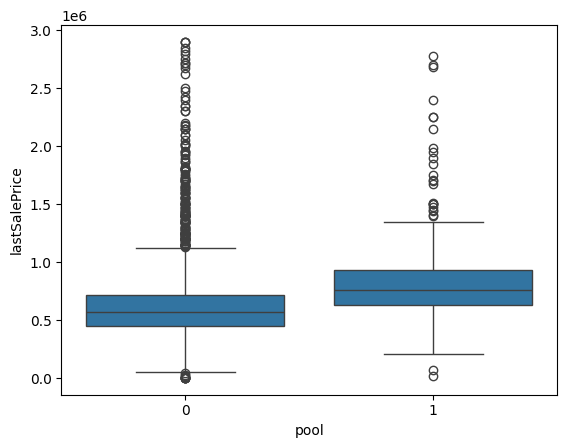

In [111]:
# Filtering price range to under 5 million

miami_filtered = miami[miami['lastSalePrice'] < 5000000]

sns.boxplot(data=miami_filtered, x='pool', y='lastSalePrice')
plt.show()

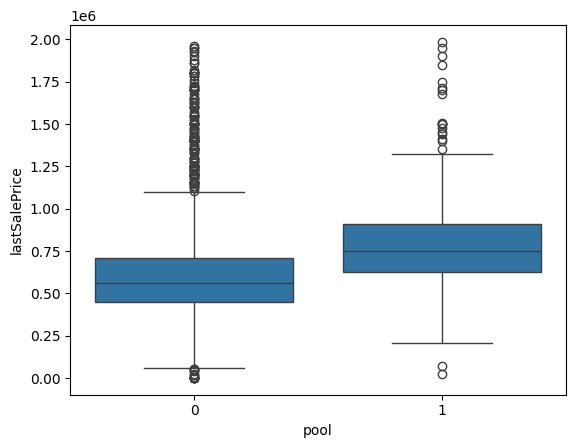

In [112]:
# Filtering price range to under 2 million

miami_filtered = miami[miami['lastSalePrice'] < 2000000]

sns.boxplot(data=miami_filtered, x='pool', y='lastSalePrice')
plt.show()

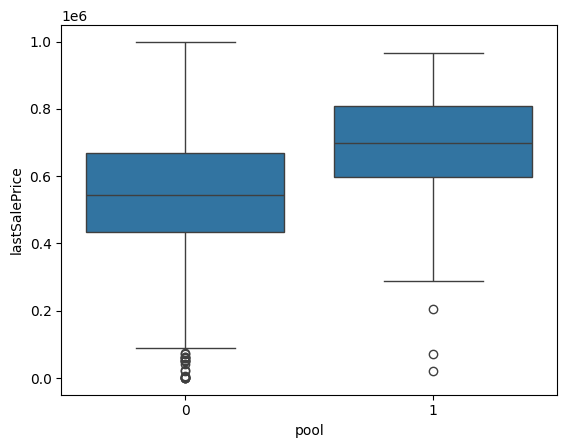

In [113]:
# Filtering price range to under 1 million

miami_filtered = miami[miami['lastSalePrice'] < 1000000]

sns.boxplot(data=miami_filtered, x='pool', y='lastSalePrice')
plt.show()

# Modeling

In [114]:
data['county'].value_counts().head(60)

county
Hillsborough    6164
Broward         5914
Lee             5324
Duval           5024
Orange          4962
Miami-Dade      4889
Palm Beach      4878
Polk            4712
Pinellas        4461
Pasco           4029
Volusia         3025
Brevard         2866
Sarasota        2793
Marion          2669
Manatee         2383
Osceola         2245
Lake            2127
Charlotte       1989
Seminole        1762
Saint Johns     1682
Saint Lucie     1297
Collier         1223
Hernando        1026
Escambia        1023
Bay             1010
Flagler          994
Clay             930
Alachua          781
Leon             773
Citrus           767
Okaloosa         750
Indian River     681
Sumter           603
Martin           478
Highlands        463
Walton           459
St. Lucie        420
Nassau           318
Monroe           302
St. Johns        211
Santa Rosa       170
Putnam           121
Hendry           101
Wakulla           70
Gulf              46
Columbia          42
Okeechobee        29
Washin

In [115]:
data.city.value_counts().head(50)

city
Jacksonville        4742
Orlando             3137
Tampa               2979
Miami               2532
Cape Coral          1964
Ocala               1901
Kissimmee           1832
Saint Petersburg    1651
Port Saint Lucie    1425
Bradenton           1271
Fort Myers          1258
Saint Augustine     1243
Sarasota            1208
Lakeland            1166
Davenport           1136
Naples              1035
Fort Lauderdale      985
Palm Bay             969
Port Charlotte       955
Pensacola            935
Palm Coast           907
Lehigh Acres         839
Riverview            818
Boca Raton           816
Boynton Beach        782
Tallahassee          775
Wesley Chapel        772
Homestead            744
West Palm Beach      720
Winter Haven         690
Punta Gorda          687
North Port           687
Spring Hill          673
The Villages         665
Venice               655
New Port Richey      653
Hollywood            642
Panama City          632
Gainesville          596
Saint Cloud         

In [116]:
city_counts = data.city.value_counts()
big_cities = city_counts[city_counts >= 1000].index

filtered = data[data.city.isin(big_cities)]

filtered.shape

(30480, 28)

In [117]:
property_types = ['Single Family','Condo']#,'Manufactured','Townhouse']
filtered = filtered[filtered['propertyType'].isin(property_types)]
filtered['propertyType'].value_counts()

propertyType
Single Family    29497
Name: count, dtype: int64

In [118]:
# Filtering by price

filtered = filtered[(filtered['lastSalePrice'] < 800000) & (filtered['lastSalePrice'] > 100000)]

In [119]:
# num_var = ['bedrooms','bathrooms','squareFootage','pool','latitude','longitude','floorCount','lastSalePrice','lotSize','m_rate','cooling','heating','fireplace','yearBuilt','garage']
num_var = ['bedrooms','bathrooms','squareFootage','pool','latitude','longitude','lastSalePrice','cooling','yearBuilt']

# model_var = ['zipCode','latitude','longitude','propertyType','bedrooms','bathrooms','squareFootage','lotSize','lastSalePrice','pool','m_rate','cooling','heating','fireplace','garage','floorCount','yearBuilt']
model_var = ['zipCode','latitude','longitude','propertyType','bedrooms','bathrooms','squareFootage','lastSalePrice','pool','cooling','yearBuilt']

filtered = filtered[model_var]
filtered.shape

(25526, 11)

In [120]:
# # Scatterplots for num_var

# columns = 3
# rows = -(-len(num_var) // columns)  

# fig, axes = plt.subplots(rows, columns, figsize=(18, 5 * rows))

# for i, col in enumerate(num_var):
#     x, y = divmod(i, columns)
#     sns.scatterplot(data=filtered, x=col, y='lastSalePrice', ax=axes[x, y])
#     axes[x, y].set_title(f'{col}')

# plt.subplots_adjust(hspace=0.8, wspace=0.8)

# plt.tight_layout()
# plt.show()

In [121]:
# Getting dummies for cat_var

cat_var = ['propertyType','zipCode']

cat_data = pd.get_dummies(filtered[cat_var])

# Recreating the dataframe with the numerical and dummy columns 

filtered = pd.concat([filtered[num_var], cat_data], axis=1)

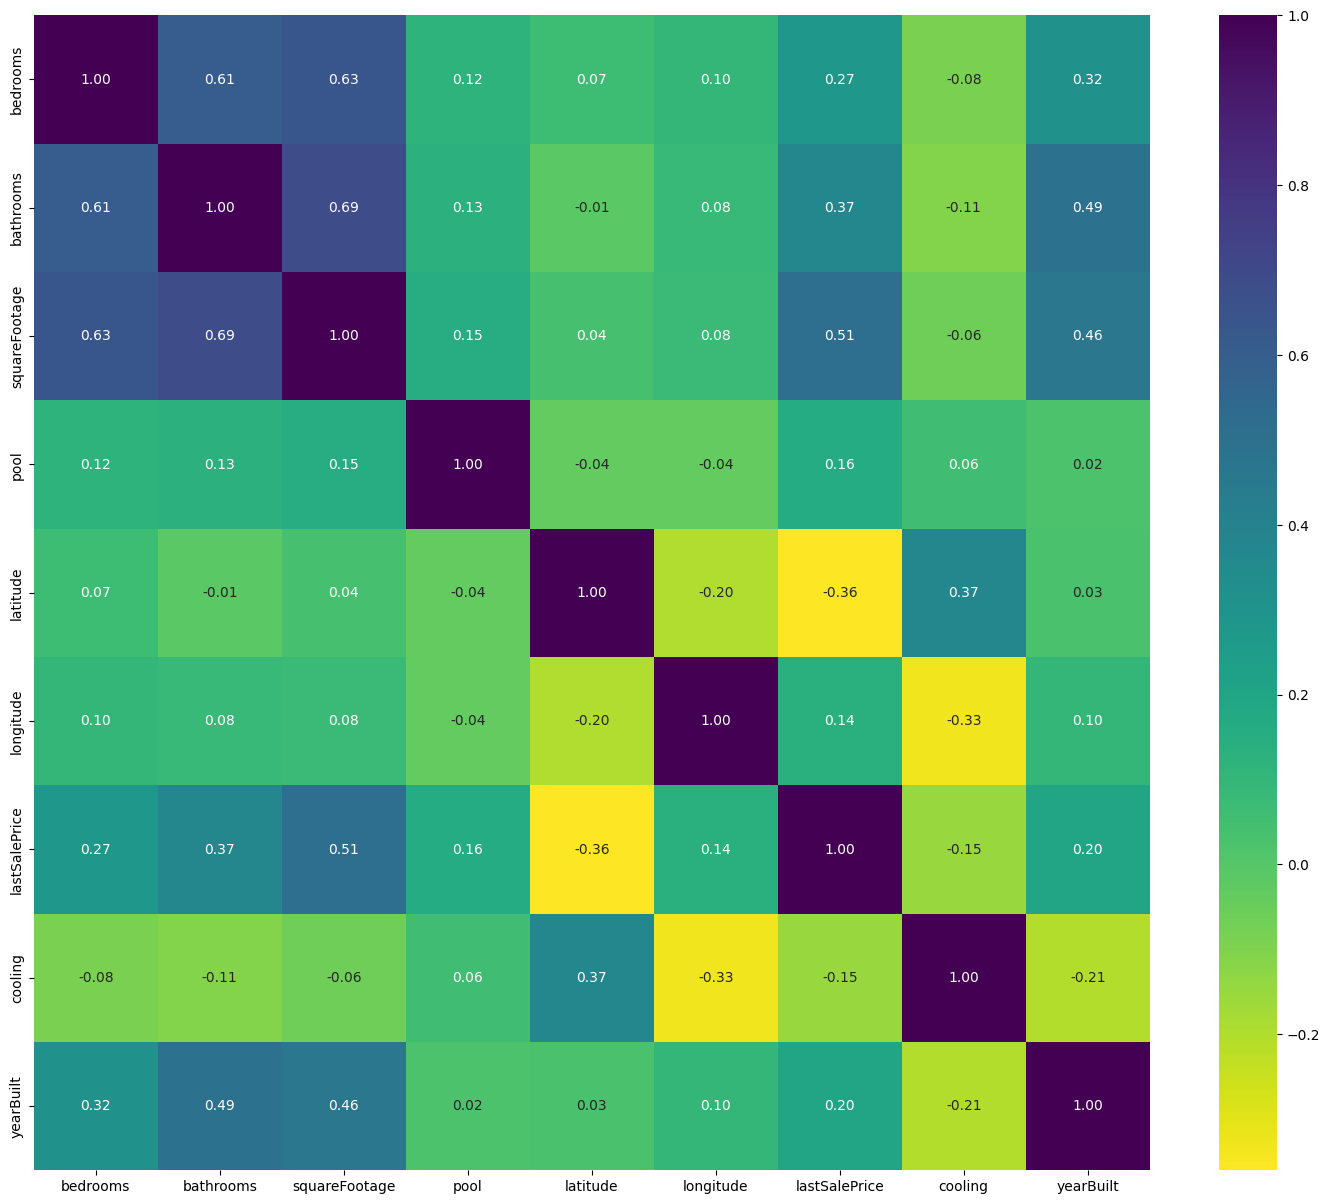

In [122]:
corr = filtered[num_var].corr()

plt.figure(figsize=(18,15))

sns.heatmap(corr,annot=True, fmt=".2f", cmap="viridis_r")

plt.show()


In [123]:
# Getting columns for dummy variables

cat_var = cat_data.columns.astype(str).tolist()

In [124]:
# Features and target, splitting data, scaling

y = filtered['lastSalePrice']
X = filtered.drop(['lastSalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=17)

In [125]:
# Scaling numerical data

num_var.remove('lastSalePrice')

X_train_num = X_train[num_var]
X_test_num = X_test[num_var]

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train[num_var])
X_test_scaled = scaler.transform(X_test[num_var])

X_train_scaled = scaler.fit_transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_num.index, columns=X_train_num.columns)

X_test_scaled = scaler.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test_num.index, columns=X_test_num.columns.astype(str))

In [126]:
# Reassembling the fully processed X sets

X_train_p = pd.concat([X_train_scaled, X_train[cat_var]], axis=1)
X_test_p = pd.concat([X_test_scaled, X_test[cat_var]], axis=1)

In [127]:
# XGBoost Regressor

xgbr = XGBRegressor()
xgbr.fit(X_train_p, y_train)

y_pred = xgbr.predict(X_test_p)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 86236.86817620146
Coefficient of determination: 0.6750000120945117


In [128]:
# Linear Regression

linear = LinearRegression()
linear.fit(X_train_p, y_train)

y_pred = linear.predict(X_test_p)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 94155.33489959716
Coefficient of determination: 0.6125753426704176


In [ ]:

# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Assume you have X_train, y_train
# model = xgboost.XGBRegressor(objective='reg:squarederror', random_state=42)

# # Define parameter grid
# param_dist = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.3],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0, 0.1, 1],
#     'reg_lambda': [1, 1.5, 2]
# }

# # Randomized search setup
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=30,  # Number of combinations to try
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Run the search
# random_search.fit(X_train, y_train)

# # Best model
# best_model = random_search.best_estimator_
# print("Best Parameters:", random_search.best_params_)

# # Evaluate on validation/test set
# y_pred = best_model.predict(X_test_p)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"Validation RMSE: {rmse:.2f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
filtered.shape

(25526, 257)

In [ ]:
# Loading cleaned data into a database

# conn = sqlite3.connect('/workspaces/mds8-final-project-bmh/data/processed/rentcast_FL_matt_cleaned.db')

# filtered.to_sql('cleaned_properties_matt', conn, if_exists='replace', index=False)

# conn.close()